## CHALLENGE SENIOR DATA SCIENTIST

With this challenge you received a dataset in csv format (input.csv).
The dataset consists of spectroscopic measurements (readings of NIR and UVVis sensors) (feature columns prefixed with nir_ or uv_, the number after the prefix is the measuring wavelength in nm) identified by a unique measurement ID (measurement_ID). Sensor readings were performed directly in the soil on three different fields (see column location) in the US. Coordinate pairs (see columns lat and lng; WGS84) specify the location where the soil readings were performed. Column soc_percent_labval contains soil organic carbon content in % determined by soil sampling of the soil layer of 0-30 cm depth close to the position of a FarmLab device reading.

Please fulfill the following tasks. Which tools you use to do so, is up to you. Make sure the reasoning and results of all steps are documented.

1. Familiarize with the dataset. Are there any issues, that could disturb further analyses? Find appropiate ways to remedy the issues.
2. Use the sensor readings and lab values to build models for prediction of soil organic carbon (SOC) content of the fields covered by measurements.

    - a. Make sure to apply adequate preprocessing to the data before model building.
    - b. Perform model building. Aim should be to create models that are likely to also give good estimates of soil organic carbon for closeby fields.
    - c. Evaluate the performance of your models.

In [61]:
%matplotlib inline
"""
Let's get started.
First of all, I import all modules that could be necessary
and print package versions for reproducibility.
"""
import sys
from collections import Counter
from random import shuffle
from collections import defaultdict
from itertools import combinations
from sys import stdout


import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.colors as mp_colors
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns
 
import scipy
from scipy import stats
import geopandas as gpd

import sklearn
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.covariance import EmpiricalCovariance
from sklearn.covariance import MinCovDet
from sklearn.svm import SVR

from scipy.signal import savgol_filter

import xgboost as xgb


__author__ = "Bogdan Kirilenko"
__email__ = "bogdan.m.kirilenko@gmail.com"
__github__ = "kirilenkobm"

print("Python interpreter and packages versions (for reproducibility):")
print(f"Python: {sys.version}")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Matplotlib: {mpl.__version__}")
print(f"Seaborn: {sns.__version__}")
print(f"Scipy: {scipy.__version__}")
print(f"Geopandas: {gpd.__version__}")
print(f"Sklearn: {sklearn.__version__}")
print(f"Xgboost: {xgb.__version__}")

# set plot style
plt.style.use('ggplot')
# set default plot size:
mpl.rcParams['figure.figsize'] = (16, 8)


# A useful function, probably will be needed later
def flatten(lst):
    """Unfold a list of lists into a single list."""
    return [item for sublist in lst for item in sublist]


def make_colors_list(num_items):
    """Create a list of N colors using cm.rainbow colormap"""
    # need to reshape(1, -1) to make arg 2D -> supress matplitlib warnings
    colors = [x.reshape(1, -1) for x in (cm.rainbow(np.linspace(0, 1, num_items)))]
    return colors

Python interpreter and packages versions (for reproducibility):
Python: 3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]
Pandas: 1.1.3
Numpy: 1.19.2
Matplotlib: 3.3.2
Seaborn: 0.11.2
Scipy: 1.5.2
Geopandas: 0.11.0
Sklearn: 0.23.2
Xgboost: 1.5.0-SNAPSHOT


In [62]:
DF_PATH = "input.csv"

# I will need access to these features quite often so
# I defined constants to reduce the number of magic strings in the code
LAT = "lat"
LNG = "lng"
FIELD_ID = "label_location"
SOC_VAL = "soc_percent_labval"
MEASUREMENT_ID = "measurement_ID"
LOCATION_CLUSTER = "location_cluster"

# Load dataset and quick look at first 10 lines.
# The index column is not named in this CSV file, but index_col=[0] is a workaround to process it correctly.
df = pd.read_csv(DF_PATH, header=0, sep=";", index_col=[0])
df.head(10)

measurement_ID        lat        lng label_location soc_percent_labval  \
0      bfnknoosf  41.279911 -92.030151        field_A    1.3750779792459   
1      kaskfansf  41.279854 -92.029450        field_A   1.51338758062445   
2      boooffnsf  41.279676 -92.027938        field_A   1.53815466576936   
3      bobbrsnsf  41.279680 -92.027932        field_A   1.52000318313218   
4      arafssrsf  41.279650 -92.027251        field_A   1.55514929544741   
5      fdaosbfsf  41.279645 -92.027268        field_A   1.53258985813933   
6      rrdsffbbk  41.278535 -92.025825        field_A   1.45714640389139   
7      snssskbbk  41.278541 -92.025829        field_A    1.2587128187166   
8      ffsrfobbk  41.278539 -92.025832        field_A   1.81424336693218   
9      koddkfdbk  41.279033 -92.026052        field_A   1.57706624996594   

   nir_1374  nir_1378  nir_1382  nir_1386  nir_1390  ...    uv_811    uv_813  \
0  0.266145  0.262247  0.256983  0.250741  0.243620  ...  0.751951  0.754726   
1  0.398604  0.393279  0.385631  0.375653  0.363615  ...  0.785473  0.787831   
2  0.503565  0.498138  0.489784  0.478757  0.465691  ...  0.675724  0.677911   
3  0.472190  0.466343  0.457769  0.446611  0.433262  ...  0.726702  0.729272   
4  0.458812  0.453379  0.445297  0.434943  0.422916  ...  0.744425  0.747514   
5  0.455395  0.450467  0.443263  0.433917  0.422832  ...  0.752418  0.755168   
6  0.402589  0.397344  0.389162  0.378638  0.366896  ...  0.791853  0.794561   
7  0.517990  0.511191  0.500902  0.487345  0.471311  ...  0.858903  0.861504   
8  0.192391  0.190408  0.186990  0.182649  0.177918  ...  0.843077  0.845899   
9  0.467251  0.461014  0.451734  0.439137  0.423775  ...  0.816246  0.819064   

     uv_815    uv_817    uv_819    uv_821    uv_823    uv_825    uv_827  \
0  0.757226  0.759433  0.761383  0.763123  0.764701  0.766164  0.767560   
1  0.790031  0.792063  0.793939  0.795676  0.797293  0.798806  0.800233   
2  0.679956  0.681848  0.683606  0.685255  0.686817  0.688319  0.689784   
3  0.731732  0.734073  0.736302  0.738431  0.740471  0.742434  0.744331   
4  0.750423  0.753136  0.755672  0.758057  0.760314  0.762471  0.764552   
5  0.757819  0.760363  0.762808  0.765166  0.767445  0.769657  0.771812   
6  0.797169  0.799670  0.802071  0.804383  0.806616  0.808780  0.810885   
7  0.863897  0.866070  0.868043  0.869844  0.871501  0.873041  0.874492   
8  0.848495  0.850850  0.852991  0.854955  0.856778  0.858498  0.860150   
9  0.821776  0.824374  0.826864  0.829257  0.831560  0.833785  0.835940   

     uv_829  
0  0.768936  
1  0.801592  
2  0.691237  
3  0.746173  
4       NaN  
5  0.773919  
6  0.812940  
7  0.875883  
8  0.861772  
9  0.838035  

[10 rows x 478 columns]

As expected, the table contains data of different measurements (with presumably unique IDs).
Each measurement has its coordinates, field location, soil organic carbon content in % (target variable), and multiple columns with NIR and UV-Vis sensors readings.

some max values >>> 99% percentile and min <<< 1% percentile
This inducates there are outliers to be cleaned up

In [63]:
# For each numeric column, I will compute basic statistics to
# - get an overall filling of the dataframe
# - immediately spot any inconsistencies in the data
# For example, if max/min value is significantly higher/lower than the 1/99th percentile,
# it is likely that there are outliers and technical issues.
df.describe(percentiles=[0.01, 0.1, 0.5, 0.9, 0.99])

lat          lng     nir_1374     nir_1378     nir_1382  \
count  1588.000000  1588.000000  1588.000000  1588.000000  1587.000000   
mean     41.196836   -91.854405     0.436951     0.432121     0.424664   
std       1.792863     3.997453     0.081382     0.080581     0.079279   
min       0.000000   -92.040639     0.132529     0.130973     0.128310   
1%       41.269389   -92.040581     0.189093     0.187536     0.185456   
10%      41.271152   -92.039035     0.322696     0.318565     0.313993   
50%      41.274985   -92.027970     0.448349     0.443988     0.435817   
90%      41.278669   -92.018719     0.519669     0.514568     0.507448   
99%      41.279798   -92.017184     0.610226     0.604921     0.598827   
max      41.279932     0.000000     0.718165     0.711620     0.700936   

          nir_1386     nir_1390     nir_1394     nir_1398     nir_1402  ...  \
count  1588.000000  1588.000000  1588.000000  1587.000000  1588.000000  ...   
mean      0.414051     0.401212     0.386795     0.371340     0.355277  ...   
std       0.077522     0.075321     0.072895     0.070254     0.067691  ...   
min       0.125009     0.121455     0.117773     0.113500     0.108929  ...   
1%        0.181856     0.177696     0.173449     0.168610     0.162143  ...   
10%       0.306893     0.298193     0.289079     0.278277     0.265809  ...   
50%       0.424674     0.411054     0.395482     0.378974     0.361825  ...   
90%       0.494853     0.479417     0.463490     0.447077     0.428388  ...   
99%       0.585815     0.570904     0.554081     0.535872     0.516589  ...   
max       0.686183     0.668080     0.647280     0.631115     0.615886  ...   

            uv_811       uv_813       uv_815       uv_817       uv_819  \
count  1588.000000  1588.000000  1588.000000  1588.000000  1588.000000   
mean      0.782566     0.784923     0.787232     0.789495     0.791715   
std       0.104090     0.104226     0.104347     0.104454     0.104550   
min       0.452464     0.454924     0.457366     0.459788     0.462191   
1%        0.496705     0.498737     0.500799     0.502888     0.504998   
10%       0.652149     0.654729     0.657091     0.659553     0.661994   
50%       0.790573     0.792795     0.795383     0.797761     0.799742   
90%       0.900004     0.902024     0.903868     0.905591     0.907110   
99%       0.979290     0.982251     0.985194     0.988111     0.990989   
max       1.829476     1.851825     1.874674     1.898045     1.921963   

            uv_821       uv_823       uv_825       uv_827       uv_829  
count  1587.000000  1588.000000  1588.000000  1587.000000  1587.000000  
mean      0.793922     0.796045     0.798164     0.800426     0.802358  
std       0.104667     0.104724     0.104807     0.104715     0.105010  
min       0.464575     0.466941     0.469291     0.471626     0.473947  
1%        0.507117     0.509265     0.511426     0.513891     0.516501  
10%       0.664835     0.667727     0.670332     0.672859     0.674391  
50%       0.801920     0.804237     0.806094     0.808091     0.810196  
90%       0.909168     0.911437     0.913605     0.916019     0.917835  
99%       0.993825     0.996570     0.999242     1.002149     1.004280  
max       1.946449     1.971528     1.997221     2.023553     2.050546  

[10 rows x 475 columns]

There are at least two obvious problems in the dataset.

##### Problem 1
The raw dataset contains 478 columns, and only 2 are supposed to be non-numeric (measurement_ID and label_location).
However, the described procedure outputs data for only 475 columns.
Some of the numeric columns contain a non-numeric value (not NaN).

Basically, the column containing the non-numeric value is soc_percent_labval: it does not appear in the output.
In the following steps, I will exclude the affected measurement.

##### Problem 2
Some columns (lat, lng, uv_815) have a max value significantly higher than 99% percentile -> potential outliers.
Probably, some of the values also have NaNs.
Lat and lng columns mostly point to Iowa, US, but the miminal lat and maximal lng values are 0.

#### Potential issue
Also, I need to check whether all the measurement IDs are unique.

In [64]:
raw_df_len = len(df)
print(f"Number of rows: {raw_df_len}")
print(f"Number of unique measurement IDs: {len(df[MEASUREMENT_ID].unique())}")
raw_df_len = len(df)
# Number of rows equals to number of unique measurement IDs -> no repeats, good.

Number of rows: 1588
Number of unique measurement IDs: 1588


In [65]:
### Continue data exploration ###

# Check for many fields we have and how many measurements were performed on each field
field_ids = list(df[FIELD_ID].unique())

print(f"There are {len(field_ids)} fields in the data set")
for field_id in field_ids:
    num_rows_with_field = len(df[df[FIELD_ID] == field_id])
    print(f"{field_id} has {num_rows_with_field} measurements")

There are 3 fields in the data set
field_A has 784 measurements
field_B has 300 measurements
field_C has 504 measurements


I decided to look at all the data first and perform the filtering later.

In [66]:
# Explore spectra-related features
# NIR spectra features start with nir_
# UV/Vis spectra features start with uv_
nir_columns = [x for x in df.columns if x.startswith("nir_")]
uvv_columns = [x for x in df.columns if x.startswith("uv_")]


# column names for spactra features contain wavelengths, extract them to check whether
# the step between readings is uniform and get values for plotting spectra data
# also, this data will be necessary for plotting
print(f"There are {len(nir_columns)} NIR measurements and {len(uvv_columns)} UV measurements")
nir_wavelengths = [int(x.split("_")[1]) for x in nir_columns]
uvv_wavelengths = [int(x.split("_")[1]) for x in uvv_columns]

print(f"NIR measurements range from {min(nir_wavelengths)} to {max(nir_wavelengths)} nm")
print(f"UV measurements range from {min(uvv_wavelengths)} to {max(uvv_wavelengths)} nm")

# Simple function to identify whether spectra resolution is uniform or not
# It will output a dict of the following structure:
# (range start, range end) -> resolution within this range
# If the resolution is uniform, the dict will contain a single key covering the whole range
def get_spectra_resolution(wavelengths):
    """For a list of wavelengts identify the resolution of the spectra"""
    diffs = [wavelengths[i] - wavelengths[i - 1] for i in range(1, len(wavelengths))]
    ranges_to_resulution = {}
    current_resulotion = diffs[0]
    current_range_start = wavelengths[0]
    current_range_end = None
    for i in range(len(diffs)):
        if diffs[i] == current_resulotion:
            current_range_end = wavelengths[i]
        else:
            ranges_to_resulution[(current_range_start, current_range_end)] = current_resulotion
            current_resulotion = diffs[i]
            current_range_start = wavelengths[i]
            current_range_end = None
    ranges_to_resulution[(current_range_start, current_range_end)] = current_resulotion
    return ranges_to_resulution

_nir_spectra_resolution = get_spectra_resolution(nir_wavelengths)
_uvv_spectra_resolution = get_spectra_resolution(uvv_wavelengths)

print()

print("NIR spectra step size:")
for (s_, e_), v in _nir_spectra_resolution.items():
    print(f"From {s_} to {e_} nm: {v} nm")
print("The same step size across the NIR spectra") if len(_nir_spectra_resolution) == 1 else None

print()
print("UV/Vi spectra step size:")
for (s_, e_), v in _uvv_spectra_resolution.items():
    print(f"From {s_} to {e_} nm: {v} nm")

print("The same step size across the UVV spectra") if len(_uvv_spectra_resolution) == 1 else None
# step size is uniform across the spectra, great

numeric_columns = [SOC_VAL, LAT, LNG] + nir_columns + uvv_columns
print(f"In total, {len(numeric_columns)} numeric columns")

There are 287 NIR measurements and 186 UV measurements
NIR measurements range from 1374 to 2518 nm
UV measurements range from 459 to 829 nm

NIR spectra step size:
From 1374 to 2514 nm: 4 nm
The same step size across the NIR spectra

UV/Vi spectra step size:
From 459 to 827 nm: 2 nm
The same step size across the UVV spectra
In total, 476 numeric columns


As we can see, the resolution is uniform.
NIR measurements are performed with a 4nm step.
The step between UV/Vi measurements is 2nm.

Since UV/Vi measurements start with 459nm, there is no UV part in uv_* readings.
They contain only visible light + a bit of near-infrared.

Next, let's identify whether there are NaN values and how widespread they are.

There is a choice between 2 strategies of how to handle them:
- Approach 1: Fill NaN values. For example, if NaN appeared in spectra data, using the average between adjacent points will work.
- Approach 2: Drop these measurements.

Since I am unfamiliar with the technical details of the spectra measurements, I cannot evaluate the reason for NaN's presence in the data.
There is a risk that the entire spectra for a given measurement are corrupted.
Therefore, I would prefer to exclude rows containing NaNs instead of filling those values.
However, if NaN values are widespread and a considerable number of measurements, I will think about filling values again.

### Data filtering and preparation
In the following steps, I will filter the data.
- First, I remove measurements containing NaN or non-numeric values.
- Then, I will filter geospatial data. Also, I will look closely at the coordinates; maybe they show something interesting.
- Afterward, I will check, filter, and normalize spectral data.

In [67]:
nn_percentile = df[uvv_columns + nir_columns].describe(percentiles=[0.99]).T["99%"].T

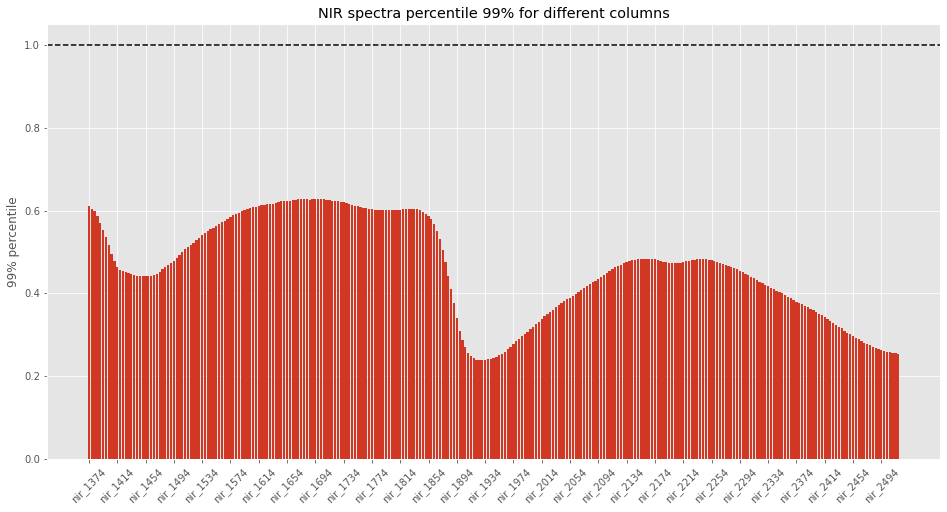

In [68]:
plt.bar(nir_columns, nn_percentile[nir_columns], color="#d13824")
plt.xticks(np.arange(0, len(nir_columns) + 1, 10), rotation=45)
plt.ylabel("99% percentile")
plt.title("NIR spectra percentile 99% for different columns")
plt.axhline(y=1.0, color="black",  linestyle="dashed")
plt.show()

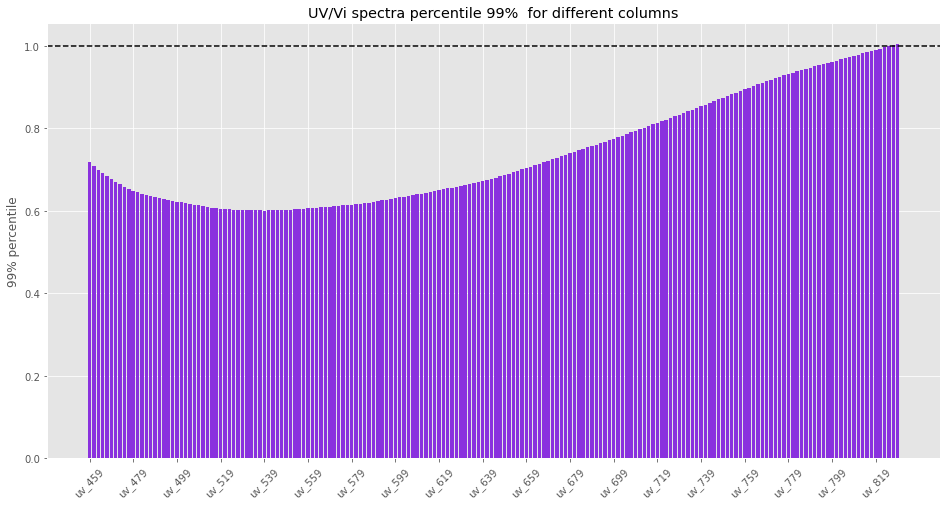

In [69]:
plt.bar(uvv_columns, nn_percentile[uvv_columns], color="#8a31de")
plt.xticks(np.arange(0, len(uvv_columns) + 1, 10), rotation=45)
plt.ylabel("99% percentile")
plt.title("UV/Vi spectra percentile 99%  for different columns")
plt.axhline(y=1.0, color="black",  linestyle="dashed")
plt.show()

In [70]:
### Filtering data ###

# select columns containining NANs
nanvals = df.isna().sum()
print(f"Total number of NaN values in the dataframe: {nanvals.sum()}")
col_to_nan_num = Counter(nanvals[nanvals > 0].to_dict())
print("Column name to the number of NANs:")
print(col_to_nan_num.most_common())
# Each column containing NaNs has only 1 NaN value.
# There is no outliers in this respect.

# Select rows containing NANs to exclude from the analysis
# I will keep those NaN-containing rows separately.
# May be an idea for another kind of analysis: 
# to check whether such measurements are indeed corrupted or may be helpful.
print()
rows_with_nans = df[df.isna().any(axis=1)]
measurements_with_nans = set(rows_with_nans[MEASUREMENT_ID])
print(f"There are {len(measurements_with_nans)} individual measurements containing Nan values")

# Check whether NaN - containin measurements originate from the same field or not?
fields_with_nans = Counter(rows_with_nans[FIELD_ID])
print(f"Field to number of measurements with Nan values: {fields_with_nans.most_common()}")

# Remove rows with NANs
print(f"Dataframe before removing rows with NANs: {len(df)}")
df.dropna(inplace=True)
print(f"Dataframe size after dropping NaN values: {len(df)}")

Total number of NaN values in the dataframe: 11
Column name to the number of NANs:
[('nir_1382', 1), ('nir_1398', 1), ('nir_1542', 1), ('nir_2110', 1), ('nir_2138', 1), ('nir_2294', 1), ('nir_2318', 1), ('uv_571', 1), ('uv_821', 1), ('uv_827', 1), ('uv_829', 1)]

There are 10 individual measurements containing Nan values
Field to number of measurements with Nan values: [('field_A', 7), ('field_C', 2), ('field_B', 1)]
Dataframe before removing rows with NANs: 1588
Dataframe size after dropping NaN values: 1578


Then, I should for another type of errors: whether all data types are aligned.
For example, whether there are strings, or special characters in numbers, and so on.

In [71]:
# Previous analysis showed that in some row(s), the SOC (soil organic carbon content) value is non-numeric.
# Here, I exclude all rows containing non-numeric values in numeric columns.
# I could've done it only for the SOC column, but just in case will do it for the entire data frame.
df_bool_mask_all_numbers_intact = df[numeric_columns].apply(pd.to_numeric, errors='coerce').notnull().all(axis=1)

# keep rows containing non-numeric values separately
broken_rows = df[~df_bool_mask_all_numbers_intact].copy() 

# Let's print rows that contain non-numeric values in numeric columns and have a look
print(broken_rows)
print("Number of rows with non-numeric values:")
print(len(broken_rows))

# One measurement contains "<0.6" value in soc_percent_labval
# clearly a mistake, I will drop it:
df = df[df_bool_mask_all_numbers_intact]
print(f"Dataframe size after removing rows with non-float values in numeric columns: {len(df)}")

# Indeed, only the target variable was affected, converting it to numeric
df[SOC_VAL] = pd.to_numeric(df[SOC_VAL])

     measurement_ID        lat        lng label_location soc_percent_labval  \
1501      brsaffskb  41.276975 -92.020306        field_C               <0.6   

      nir_1374  nir_1378  nir_1382  nir_1386  nir_1390  ...    uv_811  \
1501  0.460442  0.453972  0.444574  0.432318  0.417618  ...  0.881886   

        uv_813   uv_815   uv_817    uv_819    uv_821    uv_823   uv_825  \
1501  0.883543  0.88514  0.88668  0.888167  0.889605  0.890998  0.89235   

        uv_827    uv_829  
1501  0.893666  0.894949  

[1 rows x 478 columns]
Number of rows with non-numeric values:
1
Dataframe size after removing rows with non-float values in numeric columns: 1577


I will continue data filtering and preparation.
There are 2 main directions of work:

1) Geographic data. I will check whether there are outliers, and whether the data makes sense at all.
Find out, whether there are any patterns or inconsistencies.
2) Spectra data. I will separately analyse UV/Vi and NIR readings. I will also check whether
spectra data has no outliers, or issues, and then will normalize it.

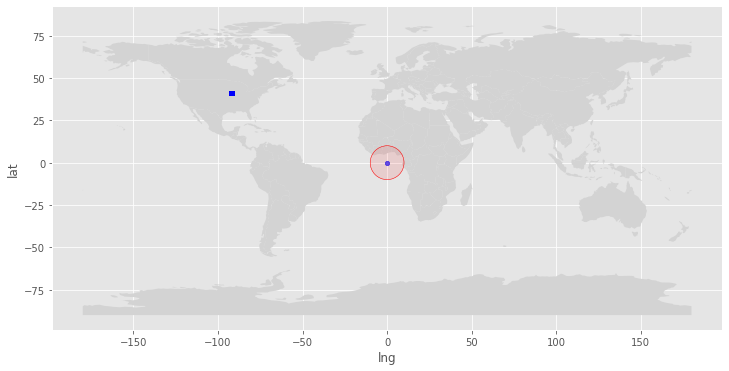

In [72]:
# The first level of magnification is plot coordinates on the world map to determine whether there are outliers.
# Ideally, all measurements should be mapped to Iowa, US.
# However, due to technical reasons and geolocation errors, the measurements can be potentially mapped anywhere.

fig, ax = plt.subplots(figsize=(12, 8))
world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world_map.plot(color="lightgrey", ax=ax)
df.plot(x=LNG, y=LAT, kind="scatter", c="blue", ax=ax, alpha=0.3)

# mark outliers located around 0, 0
circle_1 = plt.Circle((0, 0), 10, color='r', fill=False, alpha=1)
circle_2 = plt.Circle((0, 0), 10, color='r', fill=True, alpha=0.1)
ax.add_patch(circle_1)
ax.add_patch(circle_2)

plt.show()

There are outliers; GPS pointed some measurements to the Atlantic Ocean.
Indeed, there is no soil to be measured, and those values can be dropped.
In fact, LAT > 10 condition is sufficient to trim those outliers.

In [73]:
# Identify min/max lng/lat values for plotting
# remove outliers, the plot suggests that all outliers are
# around 0.0
# LAT > 10 is sufficient for our situation
# in more complex cases, I would remove everything outside Iowa borders at least
df_ = df[(df[LAT] > 10)]
LAT_MIN = df_[LAT].min()
LAT_MAX = df_[LAT].max()
LNG_MIN = df_[LNG].min()
LNG_MAX = df_[LNG].max()

# of course, there can be inconsistencies in coordinates in Iowa
# I will check this later

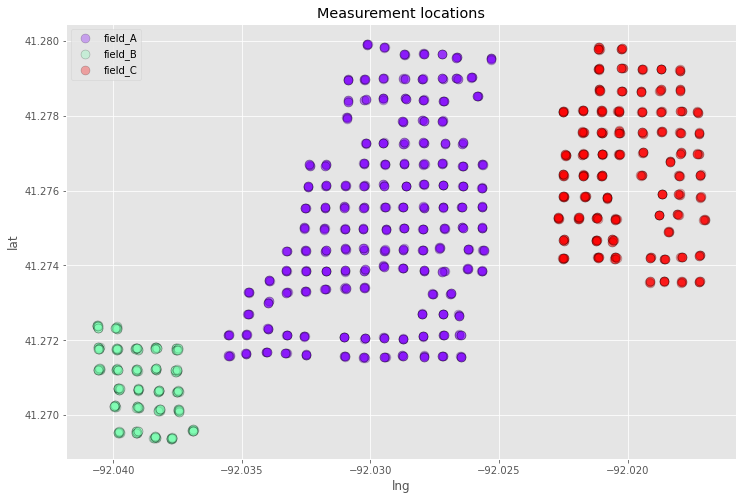

In [74]:
# Plotting borders inferred from data
# I added some room for plotting range
LAT_LIM_PLOT_SOUTH = LAT_MIN - (LAT_MIN / 100)
LAT_LIM_PLOT_NORD = LAT_MAX + (LAT_MAX / 100)

# I am planning to plot measurements related to different fields in different colors.
fig, ax = plt.subplots(figsize=(12, 8))
colors = make_colors_list(len(field_ids))

for field_id, color in zip(field_ids, colors):
    coords_for_this_field = df[df[FIELD_ID] == field_id][[LAT, LNG]]
    # Since I did not exclude outliers from the dataset yet (will do it later),
    # I exclude them on this step
    coords_for_this_field_left = coords_for_this_field[(coords_for_this_field[LAT] < LAT_LIM_PLOT_NORD) &
                                                       (coords_for_this_field[LAT] > LAT_LIM_PLOT_SOUTH)]

    coords_for_this_field_left.plot(x=LNG,
                                    y=LAT,
                                    kind="scatter",
                                    ax=ax,
                                    color=color,
                                    s=80,
                                    alpha=0.3,
                                    edgecolors="black",
                                    label=field_id)

plt.title("Measurement locations")
plt.legend()
plt.show()

# No geographical outliers outside those mapped to the Atlantic Ocean
# Fields are also properly separted in the map
# Some points were measured a few times -> points can be clustered using this principle
# idea 1: check whether there is any correlation between location and COA
# idea 2: check how similar are COA values in the same location

There are no geographical outliers outside those mapped to the Atlantic Ocean.

Fields are also adequately separated on the map.
Every point was measured several times -> I will cluster this data later.
The clusters, I believe, will provide a better understanding of data.


This leads me to the following ideas:

- Idea 1: check whether there is any correlation between location and SOC/spectra values.
- Idea 2: check how similar SOC/Spectra values are in the exact location


Although the fields are adequately separated, there are gaps in fields A (purple) and C (red).
To check whether these gaps have any reason under the hood, I mapped the points to the Google maps screenshot in Photoshop for the analyzed area.
There is no 100% mapping precision, but good enough for quick look.

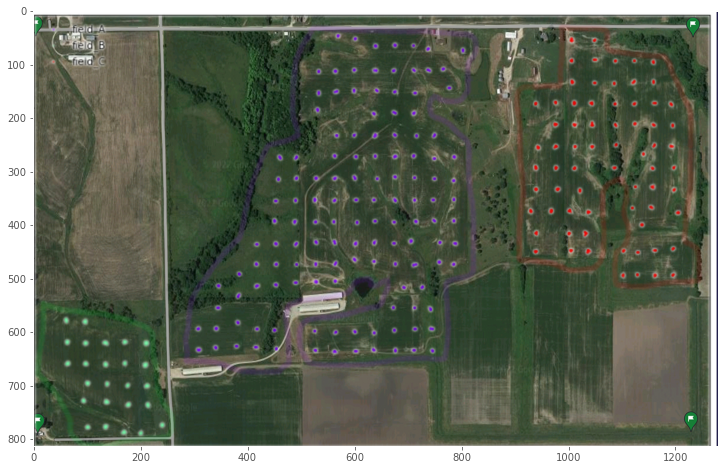

In [75]:
sattelite_meas_img = mpimg.imread("measurements_on_sattelite.jpg")
imgplot = plt.imshow(sattelite_meas_img)
plt.grid(False)
plt.show()

Most of the gaps are well explained by buildings, pond, field geometry, etc.

In [76]:
# Exclude geographical outliers from the dataframe
measurements_geo_outliers = set(df[(df[LAT] > LAT_LIM_PLOT_NORD) | (df[LAT] < LAT_LIM_PLOT_SOUTH)][MEASUREMENT_ID])
print(f"There are {len(measurements_geo_outliers)} geographic outliers")

# I saved IDs of the outliers in a separate set in case I'll like to investigate them further.

print(f"Dataframe length before removing geographical outliers: {len(df)}")
df = df[~df[MEASUREMENT_ID].isin(measurements_geo_outliers)]
df.reset_index(inplace=True, drop=True)
print(f"Dataset size after removing geographical outliers: {len(df)}")

There are 3 geographic outliers
Dataframe length before removing geographical outliers: 1577
Dataset size after removing geographical outliers: 1574


#### UV/Vi and NIR spectra analysis

Next, I will separately analyze UV/Vi and NIR spectra readings.
I will visualize them and check whether there are any clear outliers.

This is not my primary area of expertise, so that I will rely on common sense.
Likely, there are best practices I am not yet fully aware of.


##### Spectra outliers question

As I understand, the readings are ratios between reference and reflected light. Technically, this value may exceed one if and only if the measurement is influenced by parasite light. I would exclude rows that contain such values as not reliable. 

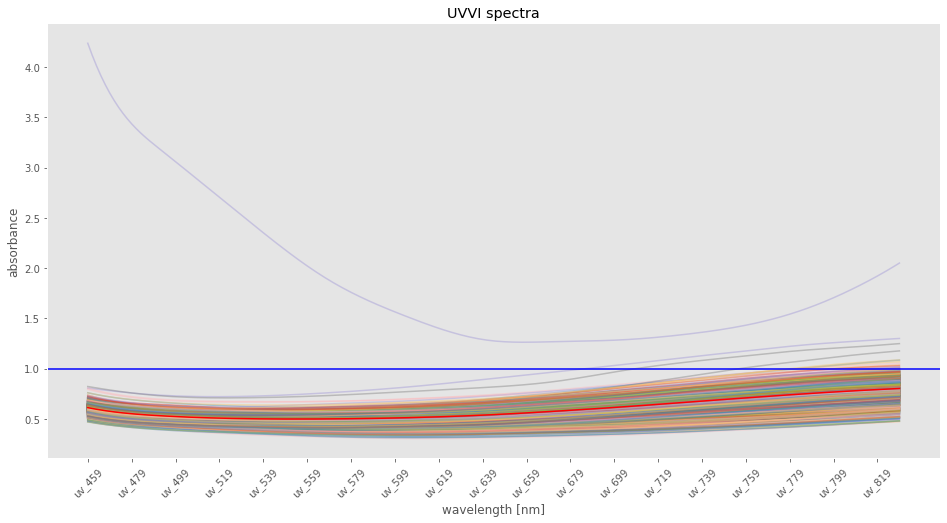

In [77]:
### Looking at UV/Vi data ###

# extact columns related to UV/Vi
uvv_df = df[uvv_columns]
# Reference spectra for UV/Vi
uvv_average = list(uvv_df.mean(axis=0))

# Plot all values
plt.plot(uvv_columns, np.array(uvv_df).T, alpha=0.4)
# And the average spectra
plt.plot(uvv_columns, uvv_average, alpha=1, color="red")

# If any value exceeds one -> I believe it is heavily affected by parasite light.
plt.axhline(y=1, color='b', linestyle='-')

plt.title("UVVI spectra")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorbance")
plt.grid()
plt.xticks(np.arange(0, len(uvv_columns) + 1, 10), rotation=45)
plt.show()

There is at least one clear outlier that has quite an exotic shape that reaches value of 4.

Some spectra reached values > 1. Some of them also clearly stand out.
I am unsure whether removing such spectra is a common practice, but I will do so in this challenge (but I admit that it may not be necessary).

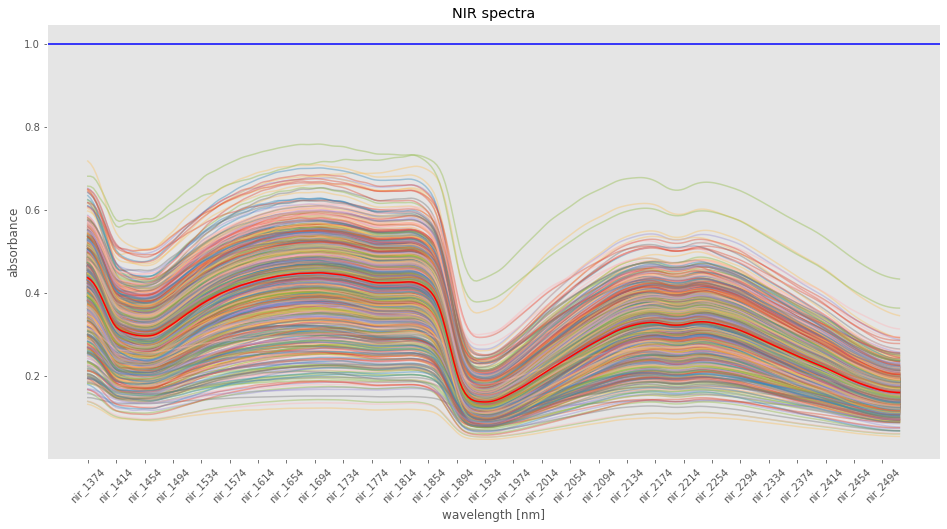

In [78]:
# Repeat the same procedure for NIR spectra

nir_df = df[nir_columns]
nir_average = list(nir_df.mean(axis=0))

plt.plot(nir_columns, np.array(nir_df).T, alpha=0.4)
plt.plot(nir_columns, nir_average, alpha=1, color="red")

plt.axhline(y=1, color='b', linestyle='-')

plt.title("NIR spectra")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorbance")
plt.grid()
plt.xticks(np.arange(0, len(nir_columns) + 1, 10), rotation=45)
plt.show()

# All NIR values are < 1
# all the measurements have the same form, but different y-axis offset

The NIR and UV/Vi (excluding outliers) spectra have a similar form but different offsets on Y-axis.
The data will need a normalization to exclude effects unrelated to chemistry (measurement conditions, fluctuations, soil structure, etc).
A common practice for normalization of such data is Multiplicative scatter correction.
This will correct the spectra to make them as close as possible to the reference spectrum.
Since I don't have a reference, I will use the mean spectrum as such.

But before I do this, I will quickly look at SOC value distribution.
This is the last value I have not looked at closely.
(I decided to separate data observation and preparation/cleaning.)


#### Soil organic carbon content values analysis

SOC ranges from [0.688883534165591 to 9.51759201550917]
Mean SOC val: 1.4362925685467138, std: 0.3635422738528254
Mean + 3*STD: 2.5269193901051903


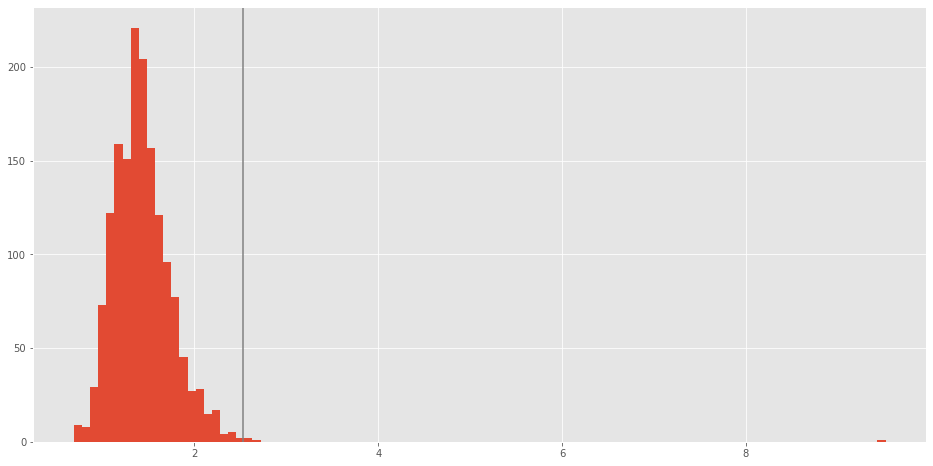

In [79]:
# Let's look at SOC value distribution once again
soc_vals = df[SOC_VAL]
plt.hist(soc_vals, bins=100)

soc_vals_mean = soc_vals.mean()
soc_vals_std = soc_vals.std()
print(f"SOC ranges from [{soc_vals.min()} to {soc_vals.max()}]")
print(f"Mean SOC val: {soc_vals_mean}, std: {soc_vals_std}")
soc_vals_mean_p_3_std = soc_vals_mean + 3 * soc_vals_std
print(f"Mean + 3*STD: {soc_vals_mean_p_3_std}")

plt.axvline(x=soc_vals_mean_p_3_std, color='grey', linestyle='-')
plt.show()

# values greater than 3 (seems like, only 1 value) can be excluded as clear outliers
# I will remove them and look at distribution again
df = df[df[SOC_VAL] < 3.0]
df.reset_index(inplace=True, drop=True)

According to this article: [Deluz et. al. 2020](https://www.frontiersin.org/articles/10.3389/fenvs.2020.00113/full):

- Practical minimal detectable change in SOC is around 0.1%, but variance can reach 0.22% (depending on the number of aliquotes + sampling depths)
- In Geneva, the average SOC for different agricultural fields ranges from 1.2 to 1.6%.

I don't know whether sampling was performed on the same or at different time points.
If the aliquots were taken simultaneously, then the expected SOC value SD should be <0.1 for a single location cluster.
I will check this later.

SOC values are in the range [0.688883534165591, 2.69053551996628]
Mean SOC val: 1.431155060951697, std: 0.3011253878180805
Mean + 3*STD: 2.3345312244059384


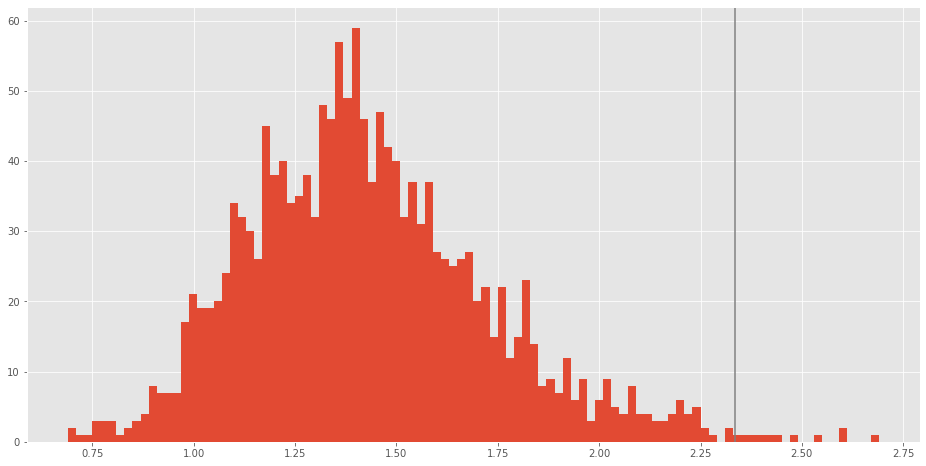

In [80]:
# Let's look at SOC value distribution once again
soc_vals = df[SOC_VAL]
plt.hist(soc_vals, bins=100)


soc_vals_mean = soc_vals.mean()
soc_vals_std = soc_vals.std()
print(f"SOC values are in the range [{soc_vals.min()}, {soc_vals.max()}]")
print(f"Mean SOC val: {soc_vals_mean}, std: {soc_vals_std}")
soc_vals_mean_p_3_std = soc_vals_mean + 3 * soc_vals_std
print(f"Mean + 3*STD: {soc_vals_mean_p_3_std}")

plt.axvline(x=soc_vals_mean_p_3_std, color='grey', linestyle='-')

# I am a bit suspicious about the values > 2.25, but will keep them:
# I would not be surprised is SOC values for farmer's fields in Iowa have a higher range than those in Geneva
# Still, the this is not 1.6% vs 5% comparison.
plt.show()

In [81]:
"""
After I removed a clear SOC outlier, I will exclude rows with spectra values > 1
I continue working with remaning data and normalize the spectra.
"""
print(f"Dataset length before excluding spectra values > 1: {len(df)}")
df = df[~(df[uvv_columns] > 1.0).any(1)]
df = df[~(df[nir_columns] > 1.0).any(1)]
df.reset_index(inplace=True, drop=True)
print(f"Dataset length after excluding spectra values > 1: {len(df)}")

uvv_df = df[uvv_columns]
nir_df = df[nir_columns]

Dataset length before excluding spectra values > 1: 1573
Dataset length after excluding spectra values > 1: 1554


#### Multiplicative scatter correction

Here, I will apply MSC to normalize the spectra and will have a look at the results.

In [82]:
def msc_correction(input_data):
    """Multiplicative scatter correction"""
    for i in range(len(input_data)):
        # for each row, subtract the mean row value
        input_data[i, :] -= input_data[i, :].mean()
 
    # Since I don't have a reference spectra, I use the mean one
    reference = np.mean(input_data, axis=0)
    # output array to be filled:
    ret = np.zeros_like(input_data)

    for i in range(len(input_data)):
        # fit a polynomial and apply the correction
        fit = np.polyfit(reference, input_data[i, :], 1, full=True)
        ret[i, :] = (input_data[i, :] - fit[0][1]) / fit[0][0] 
    return ret

nir_corrected = msc_correction(nir_df.values[:, :])
uvv_corrected = msc_correction(uvv_df.values[:, :])

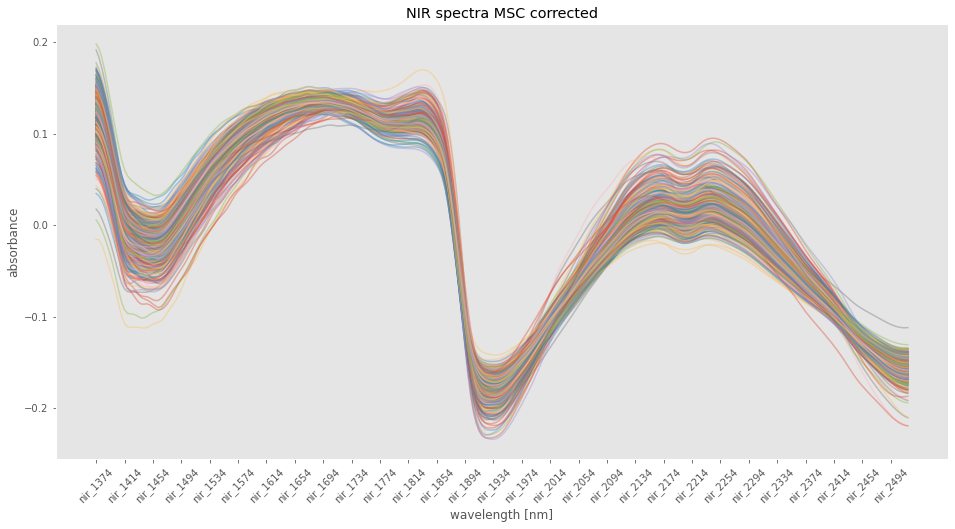

In [83]:
# Plot normalised NIR spectra
plt.plot(nir_columns, nir_corrected.T, alpha=0.4)
plt.title("NIR spectra MSC corrected")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorbance")
plt.xticks(np.arange(0, len(nir_columns) + 1, 10), rotation=45)
plt.grid()
plt.show()

Peaks in this spectra part should reflect vibrational bands for C-H, O-H, and N-H bonds.
It must be related to the problem. However, we are predicting only the organic carbon, which should be separated from inorganic (HCO3- for example).
It seems like some spectra stand out even after the normalization. I will take care of them later.

Let's look at normalized UV/Vi spectra:

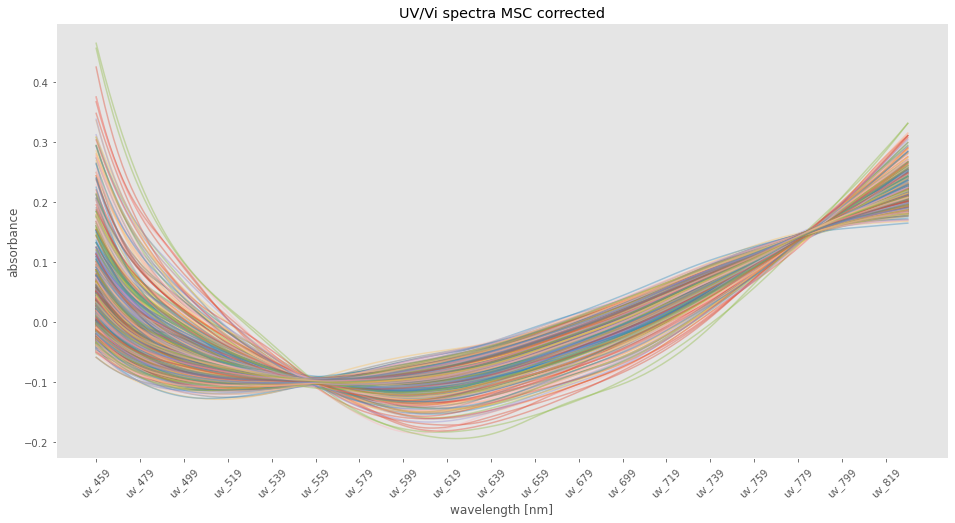

In [84]:
# Same for UV/Vi
plt.plot(uvv_columns, uvv_corrected.T, alpha=0.4)
plt.title("UV/Vi spectra MSC corrected")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorbance")
plt.xticks(np.arange(0, len(uvv_columns) + 1, 10), rotation=45)
plt.grid()
plt.show()

This looks interesting. Even after the normalization, some of the spectra slopes differ a lot.
Potentially, they are also outliers, and I will exlude them later.
I will have a closer look at spectra with higher absorbance in the blue part of the spectra (they also have a lower absorbance in the red part)

In [85]:
# Since I am going to use only the normalized data further, I will save it to a different dataframe
df_corrected_uvv = pd.DataFrame(uvv_corrected, columns=uvv_columns)
df_corrected_nir = pd.DataFrame(nir_corrected, columns=nir_columns)
non_spectra_columns = [MEASUREMENT_ID, LAT, LNG, FIELD_ID, SOC_VAL]
df_non_spectra_vals = df[non_spectra_columns].copy()
df_corrected = pd.concat([df_non_spectra_vals, df_corrected_nir, df_corrected_uvv], axis=1)
print(len(df_corrected))


1554


#### Why do UV/Vi spectra differ so much?

I will identify spectra with a higher slope and check whether they mostly come from the same field or not.
Also, I plan to map locations of such measurements on geographic data; maybe it will clarify something?

field_A red
field_B green
field_C blue


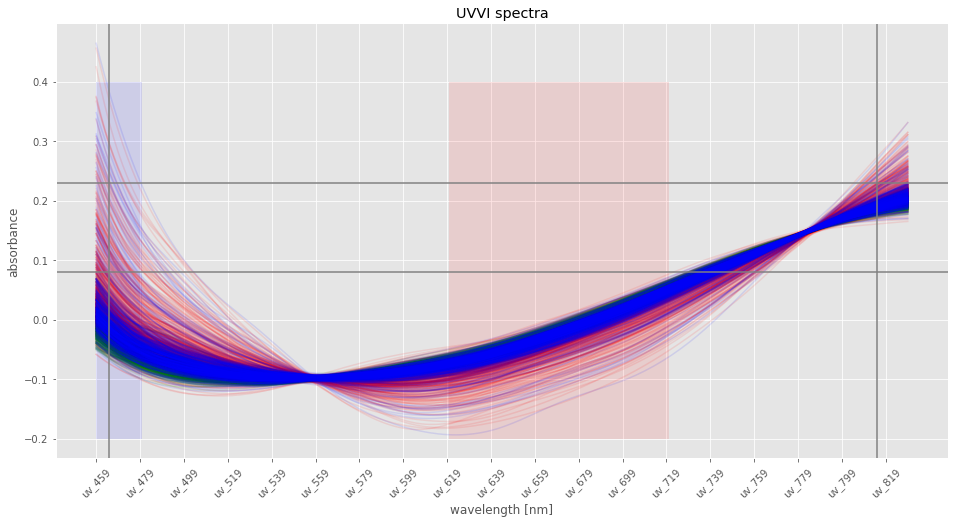

Num locations with UVVI spectra > 0.08 at 465nm or > 0.23 at 815nm: 107


In [86]:
# I will plot UV/Vi spectra again, assigning different colors to different fields.
fig = plt.figure(figsize=(16, 8))
colors = ["red", "green", "blue"]
_colnames = [MEASUREMENT_ID, LAT, LNG] + uvv_columns

# To identify spectra with a higher slope I will just use 
# absorbance values for 465 nm and 815 nm
# I defined them manually, to be honest
_thr_465 = 0.08
_thr_815 = 0.23

# for plotting: get X coordinates for 
# 465 and 815 nm thresholds on plot
_x_465 = (465 - 459) / 2
_x_815 = (815 - 459) / 2


# red and blue colors start/end in nm
RED_LIGHT_START = 620
RED_LIGHT_END = 720  # 750
BLUE_LIGHT_START = 415  # outside our range
BLUE_LIGHT_END = 480  # 495

# I am planning to highlight clusters with outliers on a map
# maybe it will provide some insights?
# I will save their locations in a separate list:
locations_uvv_outliers = []

for field_id, color in zip(field_ids, colors):
    print(field_id, color)

    uvv_for_this_field = df_corrected[df_corrected[FIELD_ID] == field_id][_colnames]
    
    # (not the best implementation)
    for row in uvv_for_this_field.itertuples(index=False):
        uvv_vals = list(row[3:])
        plt.plot(uvv_columns, uvv_vals, alpha=0.1, c=color)
        if uvv_vals[3] > _thr_465 or uvv_vals[-8] > _thr_815:
            loc_id = (row[0], row[1], row[2])
            locations_uvv_outliers.append(loc_id)

# save columns corresponding to red/blue light for further analysis
red_light_uv_columns = [x for x in uvv_columns if RED_LIGHT_START < int(x.split("_")[1]) < RED_LIGHT_END]
blue_ligth_uv_columns = [x for x in uvv_columns if BLUE_LIGHT_START < int(x.split("_")[1]) < BLUE_LIGHT_END]

# overlay plot with rectangles showing red/blue light locations
uv_spectra_start = int(uvv_columns[0].split("_")[1])
red_light_plot_start, red_light_plot_end = (RED_LIGHT_START - uv_spectra_start) / 2, (RED_LIGHT_END - uv_spectra_start) / 2
red_rect = mpatches.Rectangle((red_light_plot_start, -0.2), red_light_plot_end - red_light_plot_start, 0.6, alpha=0.1, facecolor="red")

blue_light_plot_start, blue_light_plot_end = (uv_spectra_start - uv_spectra_start) / 2, (BLUE_LIGHT_END - uv_spectra_start) / 2
blue_rect = mpatches.Rectangle((blue_light_plot_start, -0.2), blue_light_plot_end - blue_light_plot_start, 0.6, alpha=0.1, facecolor="blue")

plt.gca().add_patch(red_rect)
plt.gca().add_patch(blue_rect)

# illustrate the thresholds
plt.axhline(y=_thr_465, color='grey', linestyle='-')
plt.axhline(y=_thr_815, color='grey', linestyle='-')
plt.axvline(x=_x_465, color='grey', linestyle='-')
plt.axvline(x=_x_815, color='grey', linestyle='-')


plt.title("UVVI spectra")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorbance")
plt.gca().yaxis.grid(True)
plt.xticks(np.arange(0, len(uvv_columns) + 1, 10), rotation=45)
plt.show()

print(f"Num locations with UVVI spectra > {_thr_465} at 465nm or > {_thr_815} at 815nm: {len(locations_uvv_outliers)}")

# A lot of strange things happen in field A

According to the plot, most of the measurements with deviated UV/Vi spectra form were performed in field A.
There must be something interesting going on there.

I also decided to quickly check whether the absorption in red/blue parts of visible light correlate with SOC (what if?)

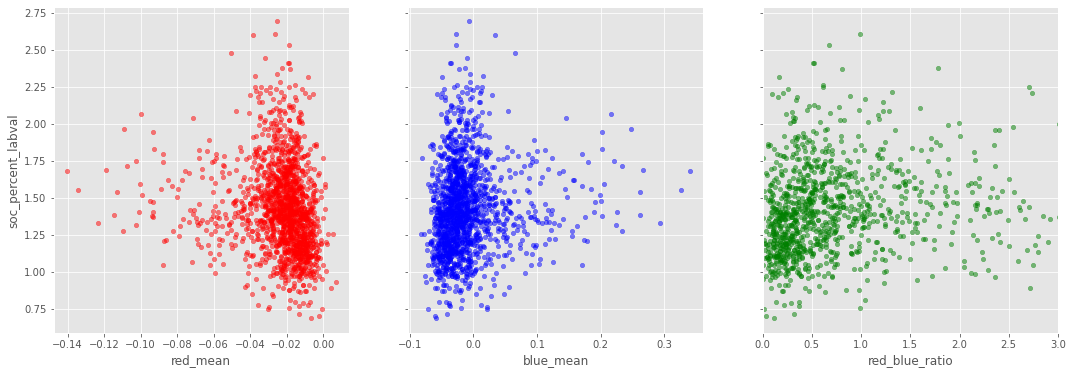

In [87]:
# Quick look: is there any correlation between SOC and red/blue absorbance? (just in case)
cols_of_interest = [SOC_VAL] + blue_ligth_uv_columns + red_light_uv_columns
df_red_blue_ligth = df_corrected[cols_of_interest].copy()

df_red_blue_ligth["red_mean"] = df_red_blue_ligth[red_light_uv_columns].mean(axis=1)
df_red_blue_ligth["blue_mean"] = df_red_blue_ligth[blue_ligth_uv_columns].mean(axis=1)
df_red_blue_ligth["red_blue_ratio"] = df_red_blue_ligth["red_mean"] / df_red_blue_ligth["blue_mean"]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(18, 6), sharey=True)
df_red_blue_ligth.plot("red_mean", SOC_VAL, kind="scatter", color="red", alpha=0.5, ax=ax1)
df_red_blue_ligth.plot("blue_mean", SOC_VAL, kind="scatter", color="blue", alpha=0.5, ax=ax2)
df_red_blue_ligth.plot("red_blue_ratio", SOC_VAL, kind="scatter", color="green", alpha=0.5, ax=ax3)
ax3.set_xlim(0, 3)

plt.show()

Well, no interesting correlation. Only the fact that with deviated spectra -> no high SOC values.

#### Removing spectra outliers

Briefly, I selected the following procedure to remove outliers from the spectra (both NIR and UV/Vi):
1) Extract the first five principal components (there are hundreds of features -> need to reduce their number).
2) For each measurement, compute the Mahalanobis distance to the center of the distribution.
3) Exclude points with a distance exceeding 3 STDs.



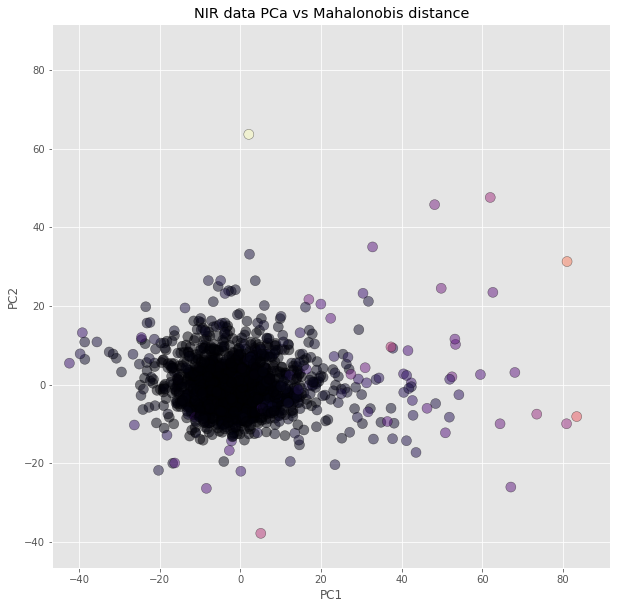

NRI Maholonobis distance std: 69.35007323953874, max: 377.424549323147


In [88]:
"""Remove outliers from NIR"""
pca = PCA(n_components=5)

# Runing PCA on the scaled NIR data
nir_pca_for_outlirs = pca.fit_transform(StandardScaler().fit_transform(nir_corrected))
# define plotting limits
ax_min, ax_max = nir_pca_for_outlirs.min() * 1.1, nir_pca_for_outlirs.max() * 1.1

# Measure Mahalanobis distance between each sample and the rest of the samples
nri_robust_cov = MinCovDet().fit(nir_pca_for_outlirs[:, :5])
nri_m_dist = nri_robust_cov.mahalanobis(nir_pca_for_outlirs[:, :5])

# Since I use 5 dimensions, I will use color to indicate the distance
colors = [plt.cm.magma(float(i) / max(nri_m_dist)) for i in nri_m_dist]
fig = plt.figure(figsize=(10, 10))

plt.scatter(nir_pca_for_outlirs[:, 0], nir_pca_for_outlirs[:, 1], c=colors, edgecolors='k', s=100, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.title('NIR data PCa vs Mahalonobis distance')
plt.show()

nri_m_dist_std = nri_m_dist.std()
nri_three_std = nri_m_dist_std * 3
nri_m_dist_max = nri_m_dist.max()

df_corrected["m_dist_nir"] = nri_m_dist
print(f"NRI Maholonobis distance std: {nri_three_std}, max: {nri_m_dist_max}")

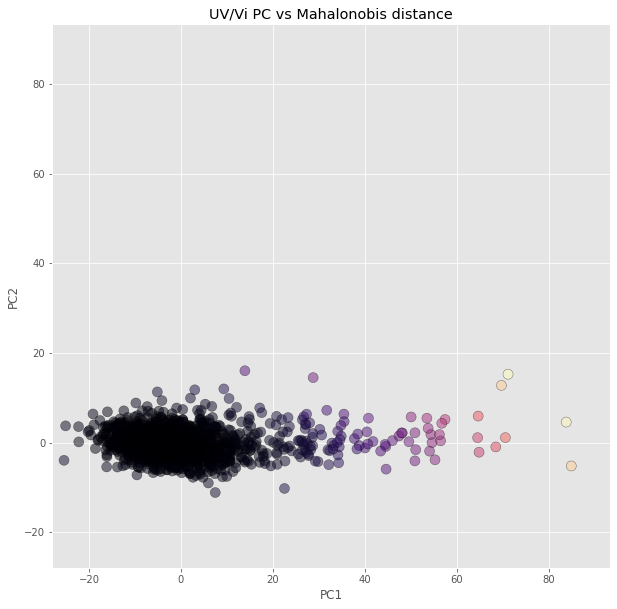

UV/Vi Maholonobis distance std: 69.35007323953874, max: 377.424549323147


In [89]:
"""Repeat the procedure for UV/Vi."""
pca = PCA()

uvv_pca_for_outlirs = pca.fit_transform(StandardScaler().fit_transform(uvv_corrected))
ax_min, ax_max = uvv_pca_for_outlirs.min() * 1.1, uvv_pca_for_outlirs.max() * 1.1
uvv_robust_cov = MinCovDet().fit(uvv_pca_for_outlirs[:,:2])
uvv_m_dist = uvv_robust_cov.mahalanobis(uvv_pca_for_outlirs[:,:2])

colors = [plt.cm.magma(float(i) / max(uvv_m_dist)) for i in uvv_m_dist]
fig = plt.figure(figsize=(10, 10))

plt.scatter(uvv_pca_for_outlirs[:, 0], uvv_pca_for_outlirs[:, 1], c=colors, edgecolors='k', s=100, alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.title('UV/Vi PC vs Mahalonobis distance')
plt.show()

uvv_m_dist_std = nri_m_dist.std()
uvv_three_std = nri_m_dist_std * 3
uvv_m_dist_max = nri_m_dist.max()

df_corrected["m_dist_uvv"] = uvv_m_dist
print(f"UV/Vi Maholonobis distance std: {uvv_three_std}, max: {uvv_m_dist_max}")

In [90]:
# Identify and count outliers
df_both_spectra_outliers_index = df_corrected[(df_corrected["m_dist_nir"] > nri_three_std) & (df_corrected["m_dist_uvv"] > uvv_three_std)].index
df_uvv_outliers = df_corrected[df_corrected["m_dist_nir"] > uvv_three_std]
df_nir_outliers = df_corrected[df_corrected["m_dist_uvv"] > nri_three_std]

print(f"Both spectra outliers: {len(df_both_spectra_outliers_index)}")
print(f"NIR outliers:", len(df_nir_outliers))
print(f"UVV outliers:", len(df_uvv_outliers))

Both spectra outliers: 1
NIR outliers: 27
UVV outliers: 42


In [91]:
print(len(df_corrected))
df_corrected.drop(df_both_spectra_outliers_index, inplace=True)
df_corrected.reset_index(drop=True, inplace=True)
print(len(df_corrected))

1554
1553


In [92]:
# I decided to exclude rows with deviated red light absorbance
# I believe they will rather disturb the analysis than help
# However, it would be interesting to undestand what causes a spectrum to look like this
print(len(df_corrected))
df_corrected = df_corrected[df_corrected[uvv_columns[0]] < 0.15].reset_index(drop=True)
print(len(df_corrected))

1553
1471


#### Cluster geographic data

As we've seen earlier, measurements were performed repeatedly at the exact locations.
I will cluster such measurements based on their coordinates.


Since I don't know the number of clusters (manual count is impractical), I cannot apply K-Means.
But distances between measurements made within one cluster are significantly lower than distances between clusters,
so agglomerative clustering with a reasonable threshold should work well.

Split into 220 clusters


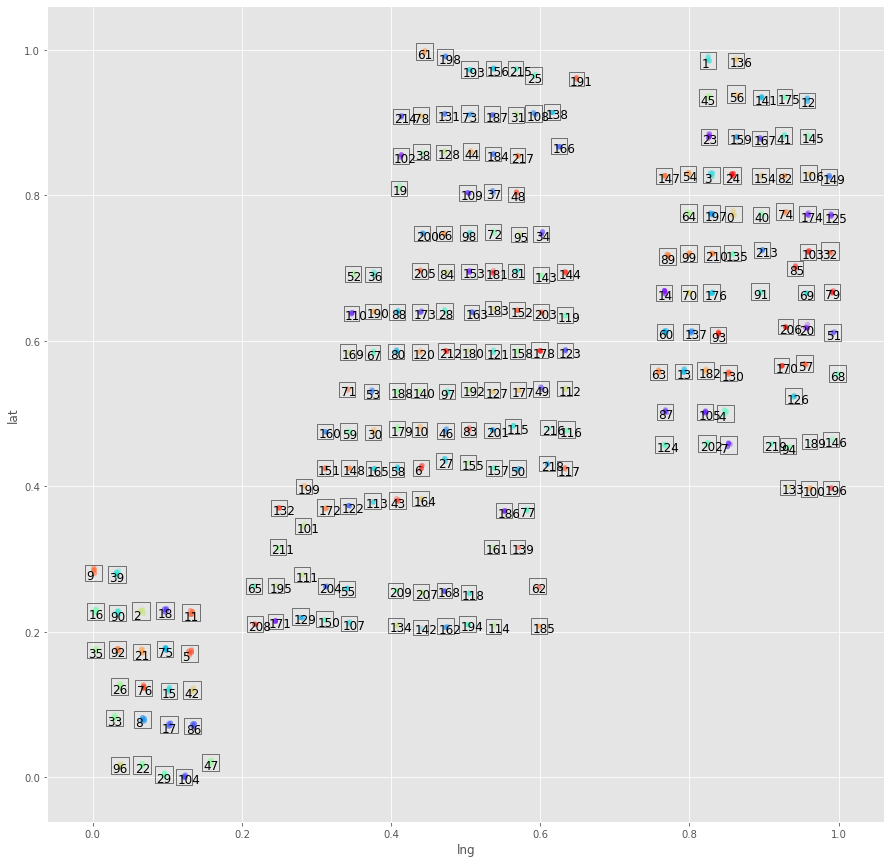

<Figure size 720x720 with 0 Axes>

In [93]:
# Here I will apply AgglomerativeClustering and visualise them for quality control
# I will overlay each cluster with a rectangle to spot any problems, if any
CLUSTER_DIST_THRESHOLD = 0.01
SQUARES_EXTRA_BOUNDS = 0.01  # clusters are quite little, need extra room to show them
SQUARES_TEXT_SHIFT = 0.002

# Selected agglomerativeClustering - I don't know the precise number of clusters
# they are already clustered well, so distance filter is gonna be enough
model_cluster = AgglomerativeClustering(n_clusters=None, distance_threshold=CLUSTER_DIST_THRESHOLD, linkage="average")
X_cluster = df_corrected[[LAT, LNG]].copy()

# Too little difference between locations, need normalization, otherwise the algorithm does not work well
X_cluster[LAT] = preprocessing.MinMaxScaler().fit_transform(np.array(X_cluster[LAT]).reshape(-1, 1))
X_cluster[LNG] = preprocessing.MinMaxScaler().fit_transform(np.array(X_cluster[LNG]).reshape(-1, 1))

# Apply clustering algorithm on rescaled data and get cluster labels
cluster_pred = model_cluster.fit_predict(X_cluster)
X_cluster["cluster"] = cluster_pred
cluster_ids = set(cluster_pred)
print(f"Split into {len(cluster_ids)} clusters")

colors = make_colors_list(len(cluster_ids))
shuffle(colors)

fig, ax = plt.subplots(figsize=(15, 15))

# Plot clustering on map + show cluster numbers above
cluster_to_num_of_measurements = {}
for cluster_id, color in zip(cluster_ids, colors):
    X_this_cluster = X_cluster[X_cluster["cluster"] == cluster_id]
    _lat_max = X_this_cluster[LAT].max() + SQUARES_EXTRA_BOUNDS
    _lat_min = X_this_cluster[LAT].min() - SQUARES_EXTRA_BOUNDS
    _lng_max = X_this_cluster[LNG].max() + SQUARES_EXTRA_BOUNDS
    _lng_min = X_this_cluster[LNG].min() - SQUARES_EXTRA_BOUNDS

    square_xy = (_lng_min, _lat_min)
    square_width = _lng_max - _lng_min
    square_height = _lng_max - _lng_min

    X_this_cluster.plot(x=LNG, y=LAT, kind="scatter", ax=ax, color=color, alpha=0.25)

    ax.add_patch(plt.Rectangle(square_xy, square_width, square_height, fill=False, color="black"))
    ax.text(_lng_min + SQUARES_TEXT_SHIFT, _lat_min + SQUARES_TEXT_SHIFT, str(cluster_id), size=12)

    # In addition, for each location I will count how many measurements we have
    num_measurements = len(X_this_cluster)
    cluster_to_num_of_measurements[cluster_id] = num_measurements

fig = plt.figure(figsize=(10, 10))
plt.show()

# Add clusters to the DF
df_corrected[LOCATION_CLUSTER] = cluster_pred

# just in case: mapping between field and clusters
# may be useful in future
field_id_to_clusters = {}
cluster_id_to_field = {}
for field_id in field_ids:
    field_clusters = set(df_corrected[df_corrected[FIELD_ID] == field_id][LOCATION_CLUSTER])
    field_id_to_clusters[field_id] = field_clusters
    cluster_id_to_field.update({cluster_id: field_id for cluster_id in field_clusters})

Looks like all clusters are separated properly.
There is no rectangle that overlays neighboring clusters.

In [94]:
for k, v in field_id_to_clusters.items():
    print(k, v)

field_A {6, 10, 19, 25, 27, 28, 30, 31, 34, 36, 37, 38, 43, 44, 46, 48, 49, 50, 52, 53, 55, 58, 59, 61, 62, 65, 66, 67, 71, 72, 73, 77, 78, 80, 81, 83, 84, 88, 95, 97, 98, 101, 102, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 127, 128, 129, 131, 132, 134, 138, 139, 140, 142, 143, 144, 148, 150, 151, 152, 153, 155, 156, 157, 158, 160, 161, 162, 163, 164, 165, 166, 168, 169, 171, 172, 173, 177, 178, 179, 180, 181, 183, 184, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 198, 199, 200, 201, 203, 204, 205, 207, 208, 209, 211, 212, 214, 215, 216, 217, 218}
field_B {2, 5, 8, 9, 11, 15, 16, 17, 18, 21, 22, 26, 29, 33, 35, 39, 42, 47, 75, 76, 86, 90, 92, 96, 104}
field_C {0, 1, 130, 3, 4, 133, 7, 136, 137, 135, 12, 13, 141, 14, 145, 146, 147, 20, 149, 23, 24, 154, 159, 32, 167, 40, 41, 170, 45, 174, 175, 176, 51, 54, 182, 56, 57, 60, 189, 63, 64, 68, 197, 196, 70, 69, 202, 74, 206, 79, 210, 82, 213, 85, 87, 89, 91, 219, 93, 94, 99, 100, 103, 105, 106

In [95]:
# just curiousity: how many measurements are in each cluster
measurement_times = Counter(cluster_to_num_of_measurements.values())
print(measurement_times)  # most of the time each point was measured 6 times, ok

Counter({6: 117, 5: 32, 9: 26, 12: 17, 11: 6, 4: 6, 3: 6, 8: 3, 10: 2, 2: 2, 1: 2, 13: 1})


Now I have clustering and can evaluate how the SOC values within each cluster differ.
I suspect the values were measured at different time points if they differ significantly.
Otherwise, I would assume the measurements were performed at close time points.

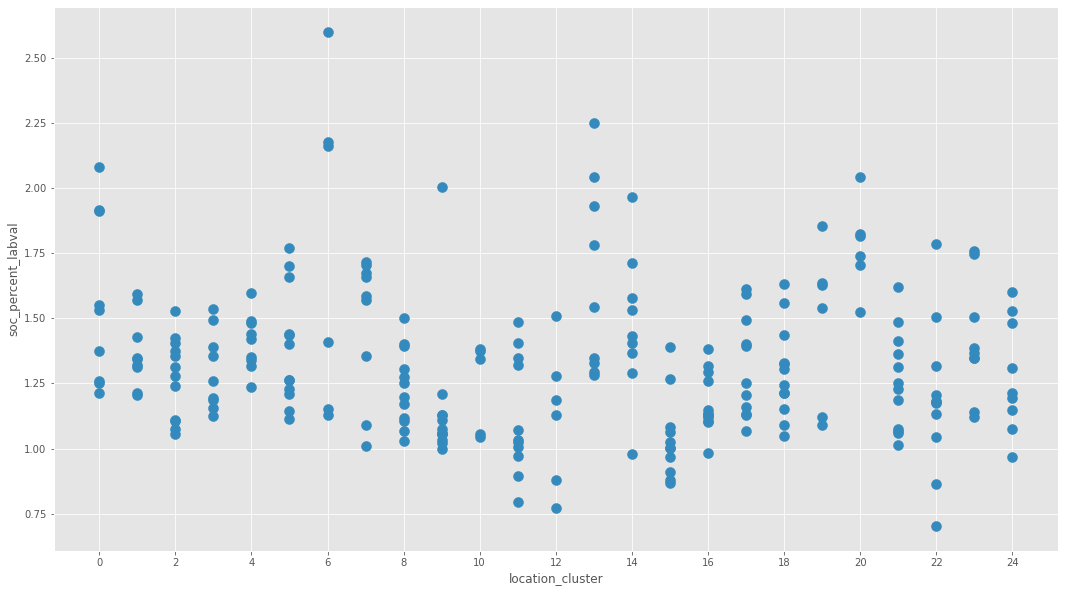

In [96]:
# I decided to plit %SOC values for first 25 cluster to have a quick look at
# the value distribution within one cluster
fig, ax = plt.subplots(figsize=(18, 10))
num_clusters_to_pick = 25
df_clusters = df_corrected[df_corrected[LOCATION_CLUSTER].isin(set(range(num_clusters_to_pick)))]
df_clusters.plot(x=LOCATION_CLUSTER, y=SOC_VAL, kind="scatter", ax=ax, s=100)
ax.locator_params(nbins=num_clusters_to_pick + 1, axis='x')
plt.show()

It seems like the SOC value varies a lot.
Most likely, the value was indeed measured at different time points.
I will compute STD for each cluster and plot it to check this assumption.
If the STD is mostly >0.1, I would say it's true.

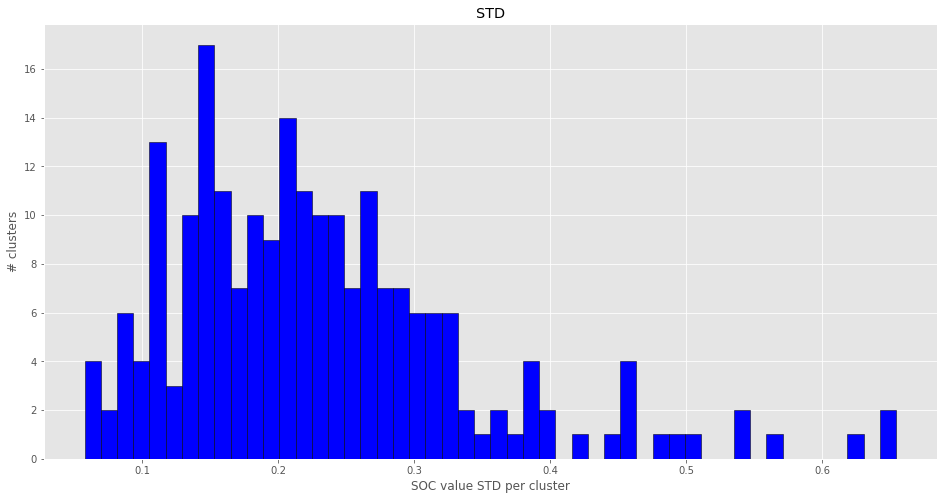

In [97]:
soc_std_per_cluster = [df_corrected[df_corrected[LOCATION_CLUSTER] == cluster_id][SOC_VAL].std() for cluster_id in cluster_ids]
plt.hist(soc_std_per_cluster, bins=50, color="b", edgecolor='k')
plt.xlabel("SOC value STD per cluster")
plt.title("STD")
plt.ylabel("# clusters")
plt.show()

SOC values deviate a lot, most of clusters have STD > 0.1.
I beleive, the measurements were taken at different timepoints.

In addition, I will plot mean, std, max, and min SOC values on the map.
Maybe, I will see some geographical pattern here?

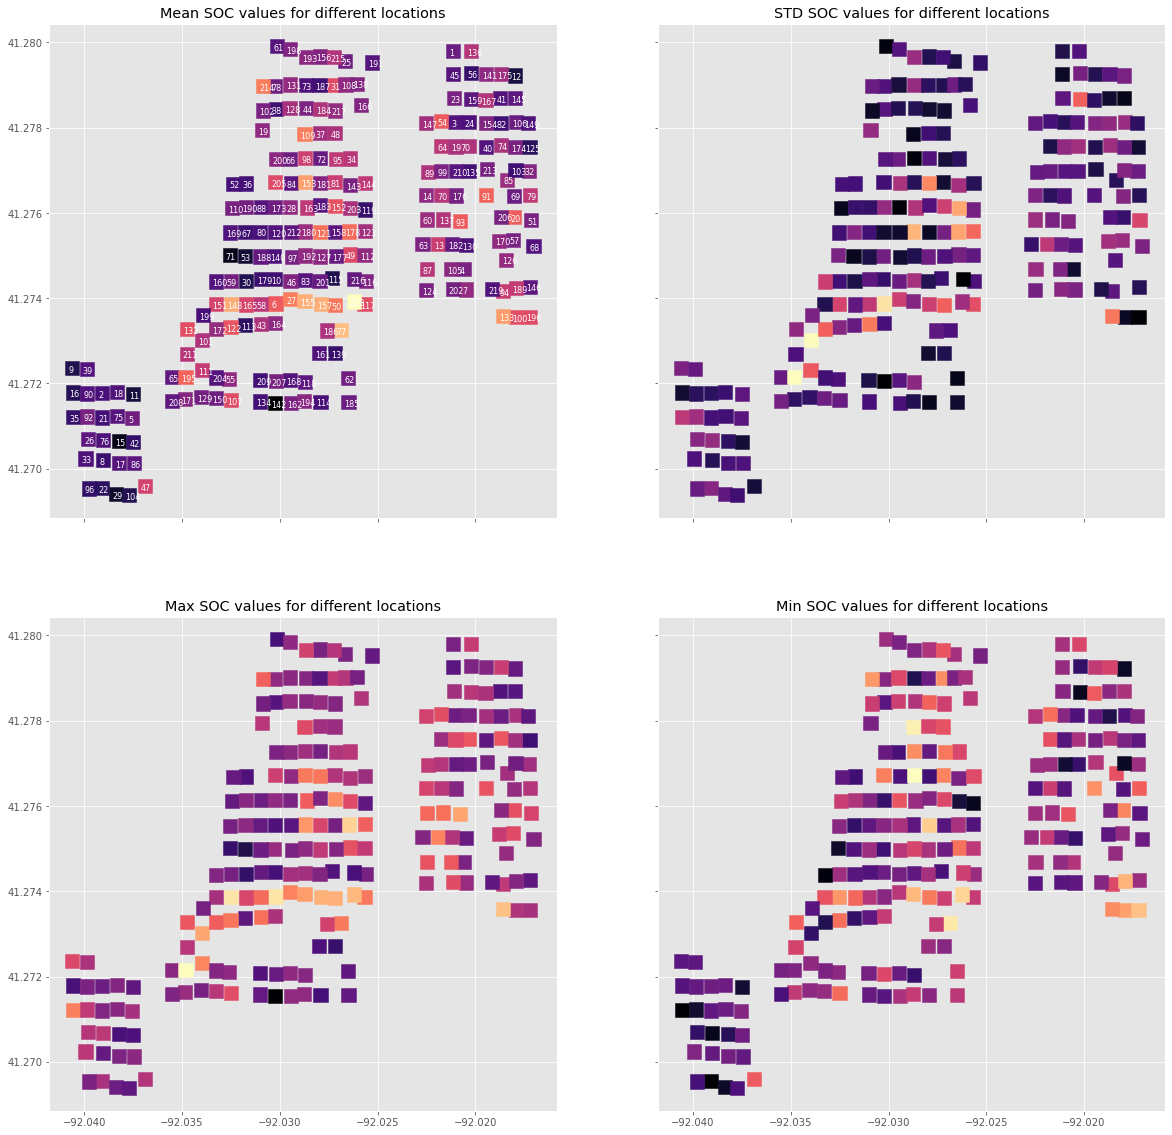

In [98]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(20, 20), sharex=True, sharey=True)

# data to plotted:
lng_vals = []
lat_vals = []
avg_soc_vals = []
max_vals = []
min_vals = []
soc_stds = []

for cluster_id in cluster_ids:
    this_cluster_data = df_corrected[df_corrected[LOCATION_CLUSTER] == cluster_id]

    # just average lat/lng values are enough for cluster localization
    cluster_lng = this_cluster_data[LNG].mean()
    cluster_lat = this_cluster_data[LAT].mean()
    lng_vals.append(cluster_lng)
    lat_vals.append(cluster_lat)

    # collect mean/ std/ max/ min values
    avg_soc_vals.append(this_cluster_data[SOC_VAL].mean())
    max_vals.append(this_cluster_data[SOC_VAL].max())
    min_vals.append(this_cluster_data[SOC_VAL].min())
    soc_stds.append(this_cluster_data[SOC_VAL].std())

    # I will also add cluster IDs on the first plot
    ax1.text(cluster_lng - 0.0002, cluster_lat - 0.0001, str(cluster_id), size=8, color="white")

max_to_min_soc_vals = [x[0] / x[1] for x in zip(max_vals, min_vals)]

ax1.scatter(lng_vals, lat_vals, c=avg_soc_vals, cmap="magma", s=200, marker='s')
ax2.scatter(lng_vals, lat_vals, c=soc_stds, cmap="magma", s=200, marker='s')
ax3.scatter(lng_vals, lat_vals, c=max_vals, cmap="magma", s=200, marker='s')
ax4.scatter(lng_vals, lat_vals, c=min_vals, cmap="magma", s=200, marker='s')

ax1.set_title("Mean SOC values for different locations")
ax2.set_title("STD SOC values for different locations")
ax3.set_title("Max SOC values for different locations")
ax4.set_title("Min SOC values for different locations")

plt.show()

Interestingly, I skipped a couple of clusters completely when filtered spectra.
I will see them on the next plot.


Locations closer to buildings and ponds in field A a higher mean SOC value and variation.
Also, the southern border of field C adjacent to a field with presumably different agriculture has a higher mean SOC.
Not sure whether this information is helpful for the rest of the analysis.

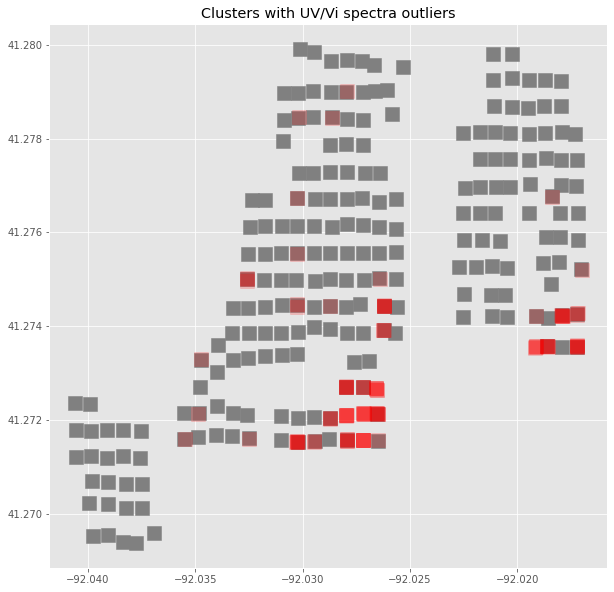

In [99]:
# let also visualise clusters that have deviated UV/Vi spectra
# something definitely happened on the south border of the firld A, and also in its
# central part of west border
fig = plt.figure(figsize=(10, 10))
plt.scatter(lng_vals, lat_vals, color="grey", s=200, marker='s')
outlie_lat = [x[1] for x in locations_uvv_outliers]
outlie_lng = [x[2] for x in locations_uvv_outliers]
plt.scatter(outlie_lng, outlie_lat, color="red", alpha=0.2, s=200, marker='s')
plt.title("Clusters with UV/Vi spectra outliers")
plt.show()

Almost the same locations are enriched with deviated UV/Vi spectra measurements.
Again, the area in field C adjacent to the neighbor field shows up. And also, the area in field A adjacent to a close-by field is red.
Those fields in the bottom-right part of the plot are not measured, but I suspect they can influence the analysis somehow. 

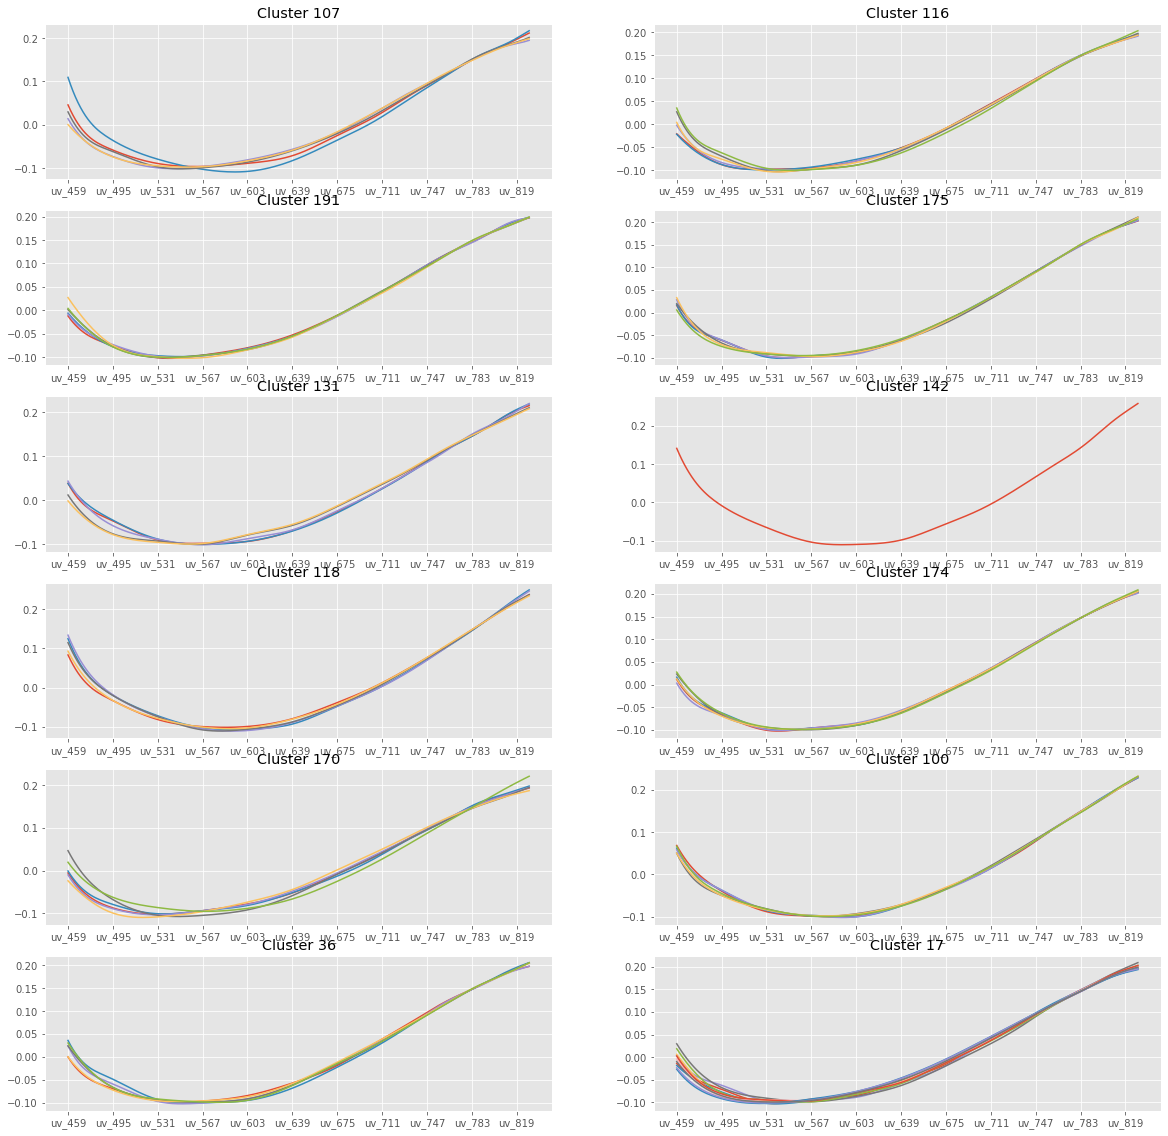

In [100]:
# Also, I decided to visualise UV/Vi spectra for some randomly selected clusters
# I will check how the UV/Vi spectra varies within the same location
import random
fig, axs_ = plt.subplots(nrows=6, ncols=2, figsize=(20, 20))
axs = flatten(axs_)
ten_random_clusters = random.sample(cluster_ids, 12)

for cluster_id, ax in zip(ten_random_clusters, axs):
    uvvi_spectra = np.array(df_corrected[df_corrected[LOCATION_CLUSTER] == cluster_id][uvv_columns])
    ax.plot(uvv_columns, uvvi_spectra.T, alpha=1)
    ax.set_xticks(np.arange(0, len(uvv_columns) + 1, 18))
    ax.set_title(f"Cluster {cluster_id}")
plt.show()

# cluster 43?

Let's have a look at NIR/UVVi plots once again.
This time, I will color them using the SOC values.

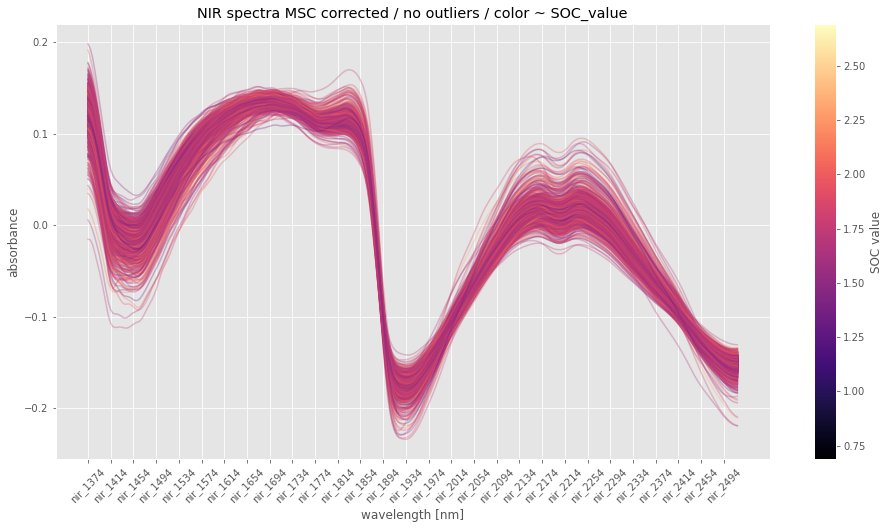

In [101]:
fig = plt.figure(figsize=(16, 8))
nir_vals = df_corrected[nir_columns].values
soc_vals = df[SOC_VAL]
colors = [plt.cm.magma(float(i) / soc_vals.max()) for i in soc_vals]

for color, row in zip(colors, nir_vals):
    plt.plot(nir_columns, row, c=color, alpha=0.3)

plt.title("NIR spectra MSC corrected / no outliers / color ~ SOC_value")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorbance")
plt.xticks(np.arange(0, len(nir_columns) + 1, 10), rotation=45)

cmap = mpl.cm.magma
norm = mpl.colors.Normalize(vmin=soc_vals.min(), vmax=soc_vals.max())
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', label='SOC value')
# plt.colorbar()
plt.show()

I can't see the correlation with the naked eye

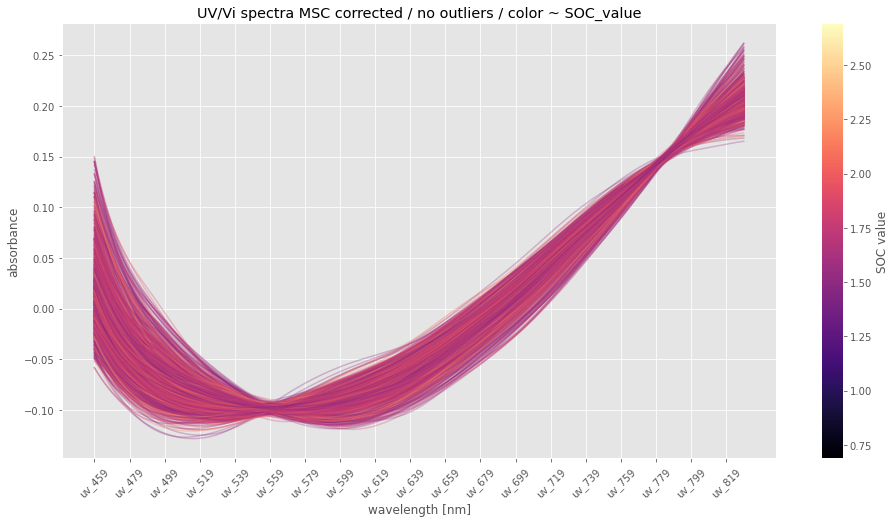

In [102]:
fig = plt.figure(figsize=(16, 8))
uvv_vals = df_corrected[uvv_columns].values
colors = [plt.cm.magma(float(i) / soc_vals.max()) for i in soc_vals]

for color, row in zip(colors, uvv_vals):
    plt.plot(uvv_columns, row, c=color, alpha=0.3)

plt.title("UV/Vi spectra MSC corrected / no outliers / color ~ SOC_value")
plt.xlabel("wavelength [nm]")
plt.ylabel("absorbance")
plt.xticks(np.arange(0, len(uvv_columns) + 1, 10), rotation=45)

cmap = mpl.cm.magma
norm = mpl.colors.Normalize(vmin=soc_vals.min(), vmax=soc_vals.max())
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             orientation='vertical', label='SOC value')
plt.show()

### Feature extraction + models training

Spectra provides hundreds of variables, which also depend on each other.
I will reduce the data dimensionality for feature extraction using techniques such as PCA.
Then I will train several models, trying different hypotheses regarding feature extraction.
I will also check whether a model trained on one field will show a reasonable estimate for other fields.

For such a class of tasks, appropriate model evaluation metrics are mean squared error and R2.
I will generally use them and build scatterplots for real value vs. predicted value.

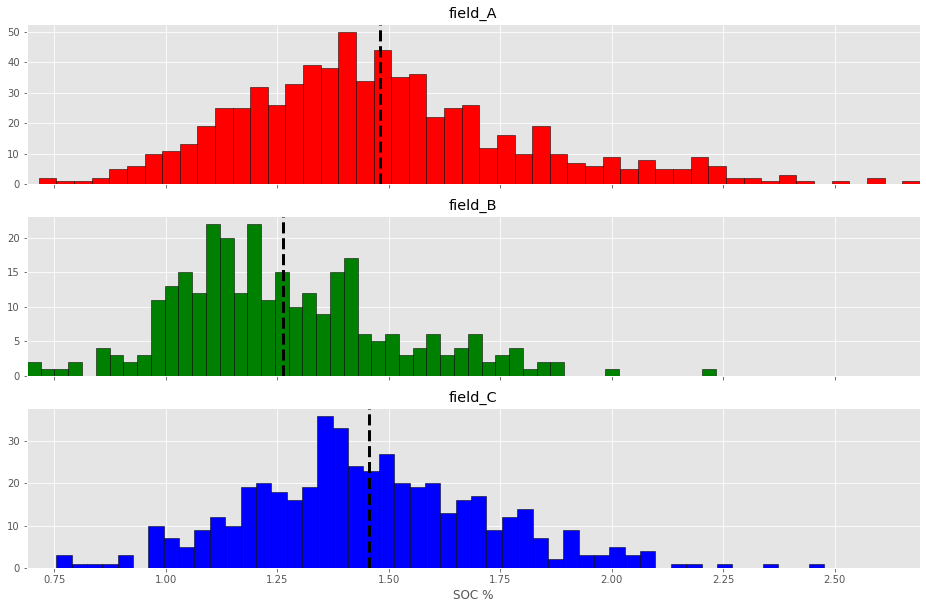

In [103]:
"""
As stated in the task:
Aim should be to create models that are likely to also give good estimates of soil organic carbon for closeby fields.


Let's see whether SOC value differs a lot between fields or not.
"""
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(16, 10), sharex=True)
colors = ["red", "green", "blue"]

global_soc_min = df_corrected[SOC_VAL].min()
global_soc_max = df_corrected[SOC_VAL].max()

for field_id, color, ax in zip(field_ids, colors, axs):
    soc_this_field = df_corrected[df_corrected[FIELD_ID] == field_id][SOC_VAL]
    soc_this_field.hist(ax=ax, bins=50, color=color, edgecolor='k')
    ax.axvline(soc_this_field.mean(), color="k", linestyle="--", linewidth=3)
    ax.set_xlim(global_soc_min, global_soc_max)
    ax.set_title(field_id)
plt.xlabel("SOC %")
plt.show()

Clearly, field B, the smallest one, differs a lot from A and C and has, in general, lower SOC values.
The aim would be to create a generalized model to handle this issue.

But first, let's define some necessary functions.

In [104]:
# A function that will train and test model on different subsets of fields.
# First, it will train on 2 and test on 1,
# then will train/test on each possible pair of fields
# and print MSE / R2 values
def eval_on_diff_fields(model, eval_df, feature_colnames):
    """Train on 2 fields and test on the 3rd.
    
    Check that trained on one subset of fields works well on others.
    """
    for i in range(len(field_ids)):
        # solution in case we had many fields
        test_field = field_ids[i]
        train_fields = set(field_ids[:i] + field_ids[i+1:])
        test_df = eval_df[eval_df[FIELD_ID] == test_field]
        train_df = eval_df[eval_df[FIELD_ID].isin(train_fields)]

        train_X = train_df[feature_colnames]
        train_y = train_df[SOC_VAL]
        test_X = test_df[feature_colnames]
        test_y = test_df[SOC_VAL]

        model.fit(train_X, train_y)
        pred = model.predict(test_X)

        mse_score = mean_squared_error(test_y, pred)
        r2_ = r2_score(test_y, pred)
        print(f"Train on {train_fields}, test on {test_field}:\nMSE: {mse_score:.4f}, R^2: {r2_:.4f}")

    # test also on all 1:1
    for (fld1, fld2) in combinations(field_ids, 2):
        fld_1_df = eval_df[eval_df[FIELD_ID] == fld1]
        fld_2_df = eval_df[eval_df[FIELD_ID] == fld2]

        fld1_X = fld_1_df[feature_colnames]
        fld2_X = fld_2_df[feature_colnames]
        fld1_y = fld_1_df[SOC_VAL]
        fld2_y = fld_2_df[SOC_VAL]

        model.fit(fld1_X, fld1_y)
        pred_1 = model.predict(fld2_X)
        mse_score = mean_squared_error(fld2_y, pred_1)
        r2_ = r2_score(fld2_y, pred_1)
        print(f"Train on {fld1}, test on {fld2}:\nMSE: {mse_score:.4f}, R^2: {r2_:.4f}")

        model.fit(fld2_X, fld2_y)
        pred_2 = model.predict(fld1_X)
        mse_score = mean_squared_error(fld1_y, pred_2)
        r2_ = r2_score(fld1_y, pred_2)
        print(f"Train on {fld2}, test on {fld1}:\nMSE: {mse_score:.4f}, R^2: {r2_:.4f}")

In [105]:
# Function to compute evaluation metrics for different models
# and build predicted vs true value scatter plots
def regression_metrics_and_plot(y_true, y_pred):
    """Calculate evaluation metrics and build regression plot"""
    mse_score = mean_squared_error(y_true, y_pred)
    r2_ = r2_score(y_true, y_pred)

    print(f"MSE: {mse_score}, r2: {r2_}")
 
    z = np.polyfit(y_true, y_pred, 1)
    fig, ax = plt.subplots(figsize=(10, 10))

    ax.scatter(y_true, y_pred, c='red', edgecolors='k', s=100, alpha=0.5)
    ax.plot(z[1] + z[0] * y_true, y_true, c='blue', linewidth=1)
    ax.plot(y_true, y_true, color='green', linewidth=1)

    plt.title(f"MSE: {mse_score}, r2: {r2_}")
    plt.xlabel("True SOC %")
    plt.ylabel("Predicted SOC %")
    plt.show()

In [106]:
def split_into_pca(num_components, data, prefix, no_plot=False):
    """Split data into N principal components and plot them"""
    pca = PCA(n_components=num_components)
    data_scaled = StandardScaler().fit_transform(data)
    # standardise the features to subtract the mean and reduce to unit variance
    data_pca = pca.fit_transform(data_scaled)
    pca_colnames = [f"{prefix}_{i + 1}" for i in range(num_components)]
    data_pca = pd.DataFrame(data_pca, columns=pca_colnames)
    if no_plot is False:
        data_pca[SOC_VAL] = (df_corrected[SOC_VAL].T * 100).astype(int)
        # also paint dots in different colors to trace how PC correlate with SOC
        sns.pairplot(data_pca, hue=SOC_VAL, palette='magma')
        plt.show()
        data_pca.drop(SOC_VAL, axis=1, inplace=True)
    return data_pca

Here, I will do appropriate data preparation for NIR and UV/Vi spectra.
I will smooth the data using savgol filter and take the 1st derivative or each.
(also I will try the second derivative if need be)

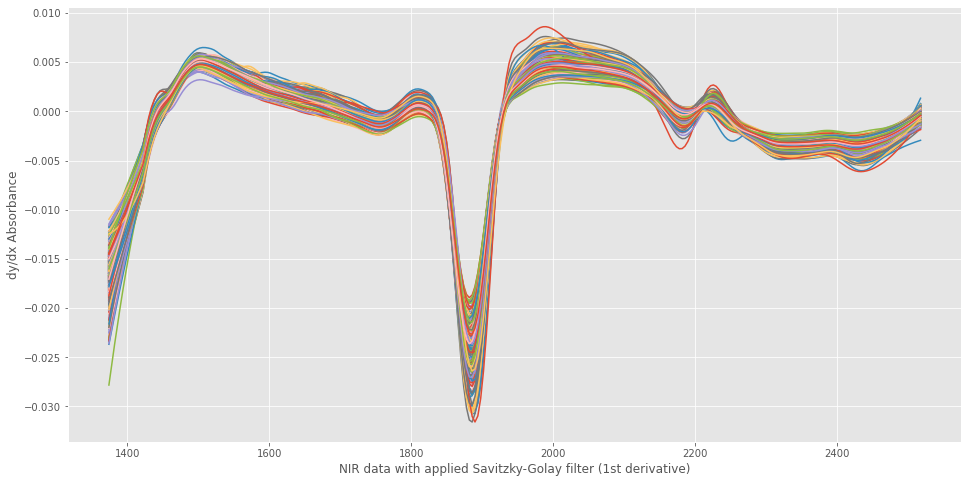

In [107]:
# select NIR and UVV sub-dataframes
X_nir = df_corrected[nir_columns]
X_uvv = df_corrected[uvv_columns]

# smoothen the NIR data and have a lootk at the result
# 1st derivative removes baseline shift - which is generally an unwanted effect
# But I will also try the 2nd derivative later, it also removes the linear term
X_nir_filt_1d = savgol_filter(X_nir, 25, polyorder=3, deriv=1)
plt.plot(nir_wavelengths, X_nir_filt_1d.T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('dy/dx Absorbance')
plt.xlabel("NIR data with applied Savitzky-Golay filter (1st derivative)")
plt.show()

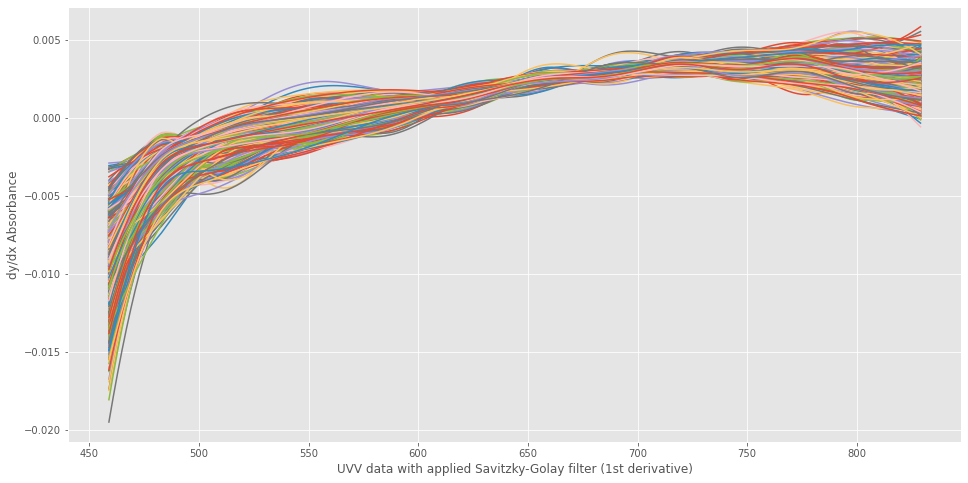

In [108]:
# The same for UV/Vi part
X_uvv_filt_1d = savgol_filter(X_uvv, 25, polyorder=3, deriv=1)
plt.plot(uvv_wavelengths, X_uvv_filt_1d.T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('dy/dx Absorbance')
plt.xlabel("UVV data with applied Savitzky-Golay filter (1st derivative)")
plt.show()

#### Let's start with basic PCA

We cannot use nir_ and uvv_ features as is and need to reduce the dimensionality of data.
One idea would be to extract principal components and train a model on them.

- First, I will extract some principal components and train a baseline model.
- Second, I will apply PLSR.
- Will play around with other methods for complexity reduction.
- I believe more advanced and specialized techniques can be used for feature extraction in this particular situation. For example, neural networks may predict the sample's specific chemical properties.

#### Baseline model

This model is not intended to show outstanding performance.
However, it will provide me with a baseline for better models.

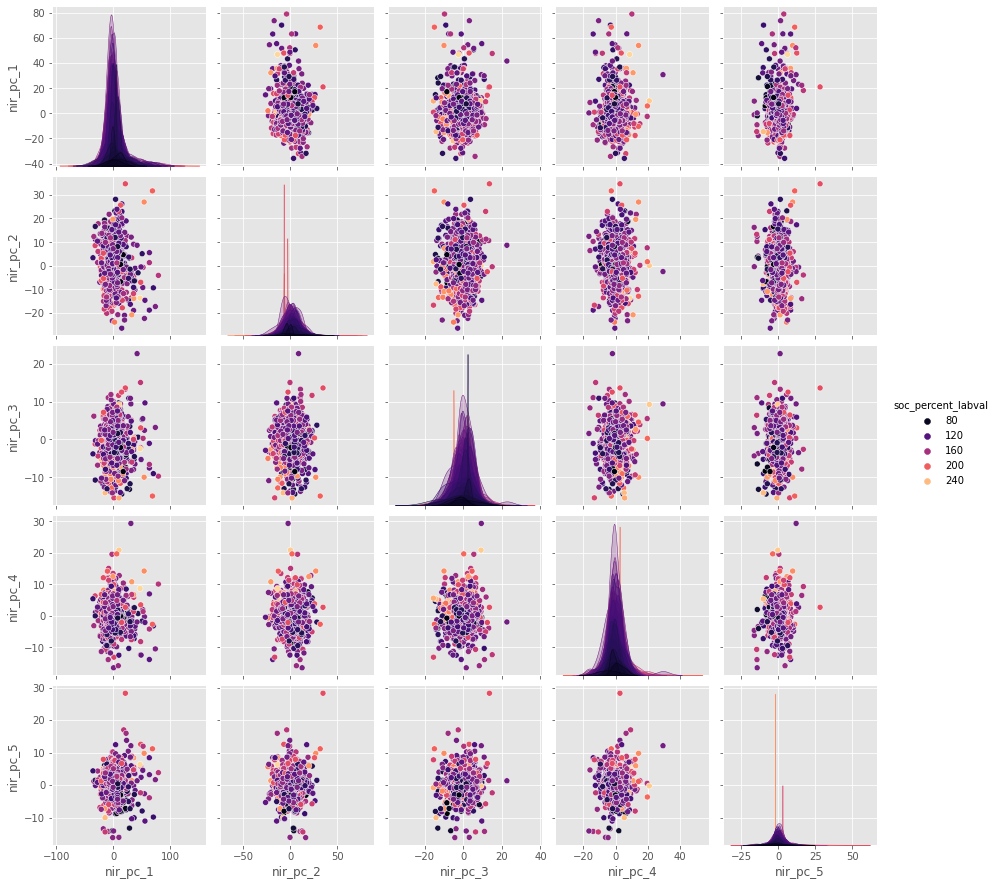

In [109]:
# Extract first 5 PC for NIR spectra 1st derivative
X_nir_1_pca = split_into_pca(5, X_nir_filt_1d, "nir_pc")

I don't see any strong correlations between PC and SOC here. But let's try this as a baseline together with UVVi PC below.

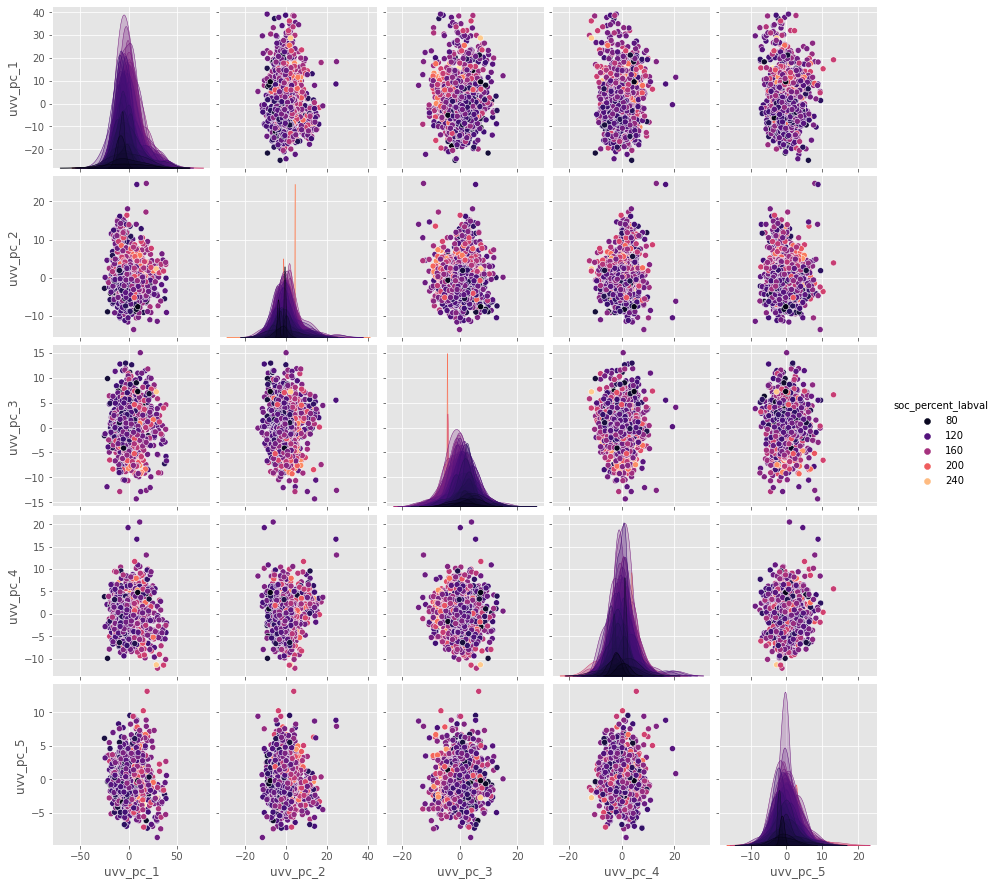

In [110]:
X_uvv_1_pca = split_into_pca(5, X_uvv_filt_1d, "uvv_pc")

MSE: 0.0828469982807672, r2: 0.09709785468812449


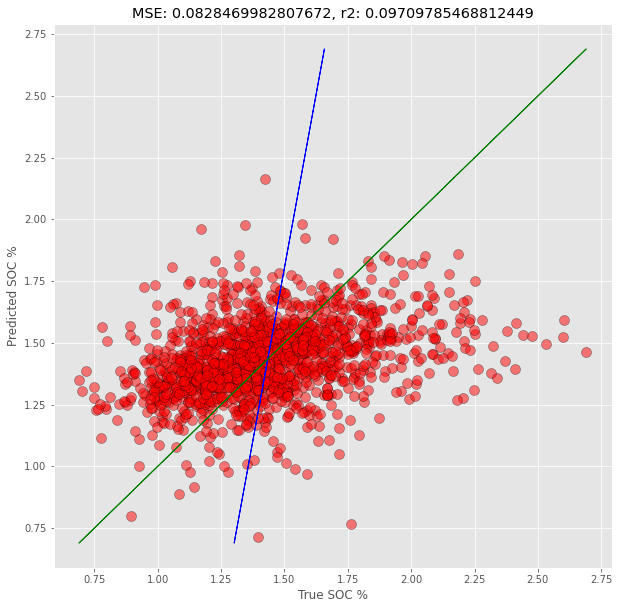

In [111]:
# Combine extracted PCs into a dataframe and perform cross-validation
X_baseline_pca = pd.concat([X_nir_1_pca, X_uvv_1_pca], axis=1)
y_baseline_pca = df_corrected[SOC_VAL]
baseline_model = LinearRegression()  # I will use a simple LinearRegression here

# cross val predict -> retuns an array of exactly the same shape as y, but produced via cross validated predictions
baseline_y_cv = cross_val_predict(baseline_model, X_baseline_pca, y_baseline_pca, cv=10)
# evaluate the baseline model
regression_metrics_and_plot(y_baseline_pca, baseline_y_cv)

Not so great quality, R^2 is pretty close to 0.
There is a significant room for improvement.

#### Let's try to improve the baseline model!

Let's try to pick a right set of PC for NRI and UVV data.
Before, I selected 5 PCs for each spectra, but those numbers were not optimised.
I will try different numbers of PC, and evaluate R2 + MSE metrics again.
Then I will pick the optimal values and train another model on them.

In [112]:
"""A function will try to split an X set into a different number of PCs.
Then, for each split, it will compute MSE and R2 scores two times:
- calibration, which is a baseline -> model makes predictions on the training data
- scores obtained via cross-validation,
Then, it will plot the metrics allowing me to pick the best number of components.

I will select a number of components that gives the best increase in MSE/R2 scores.
However, I will not just select the number that gives the highest scores to avoid overfitting.
"""

def try_different_pc_number(X_scaled):
    pc_and_scores = []

    for pc_num in range(1, 20):
        pca = PCA(n_components=pc_num)
        regressor = LinearRegression()
        X_split_into_pca = split_into_pca(pc_num, X_scaled, "xxx_pc_", no_plot=True)
        regressor.fit(X_split_into_pca, y_baseline_pca)
        y_calibration = regressor.predict(X_split_into_pca)
        y_cv = cross_val_predict(regressor, X_split_into_pca, y_baseline_pca, cv=10)

        score_c = r2_score(y_baseline_pca, y_calibration)
        score_cv = r2_score(y_baseline_pca, y_cv)
        mse_c = mean_squared_error(y_baseline_pca, y_calibration)
        mse_cv = mean_squared_error(y_baseline_pca, y_cv)

        ret_item = (pc_num, score_c, score_cv, mse_c, mse_cv)
        pc_and_scores.append(ret_item)


    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))

    pc_nums, score_cs, score_cvs, mse_cs, mse_cvs = zip(*pc_and_scores)
    ax1.plot(pc_nums, score_cs, label="R2 calibration", color="red", alpha=0.5)
    ax1.plot(pc_nums, score_cvs, label="R2 cross validation", color="blue", alpha=0.5)
    ax1.scatter(pc_nums, score_cs, color="red", alpha=0.5)
    ax1.scatter(pc_nums, score_cvs, color="blue", alpha=0.5)
    ax1.set_xlabel("PC number")
    ax1.set_ylabel("R^2")
    ax1.legend()


    ax2.plot(pc_nums, mse_cs, label="MSE calibration", color="red", alpha=0.5)
    ax2.plot(pc_nums, mse_cvs, label="MSE cross validation", color="blue", alpha=0.5)
    ax2.scatter(pc_nums, mse_cs, color="red", alpha=0.5)
    ax2.scatter(pc_nums, mse_cvs, color="blue", alpha=0.5)
    ax2.set_xlabel("PC number")
    ax2.set_ylabel("MSE")
    ax2.legend()

    plt.plot()

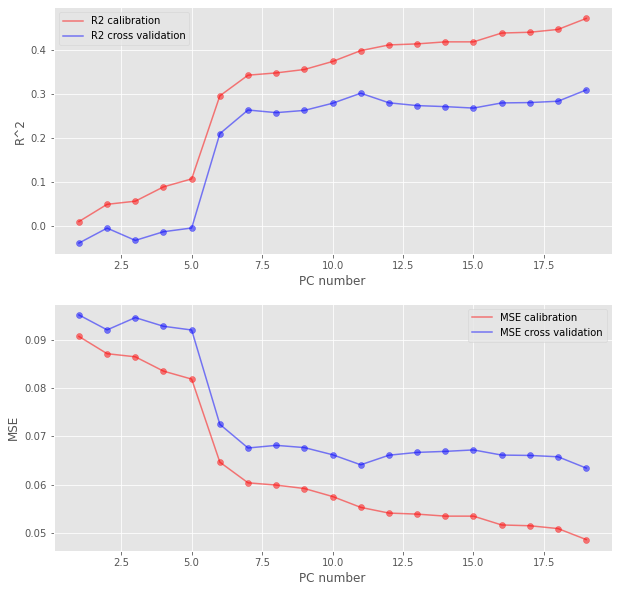

In [113]:
try_different_pc_number(X_nir_filt_1d)

Not really impressive scores, but 7 components would be the best choice for NRI.
Enough components to describe the data.

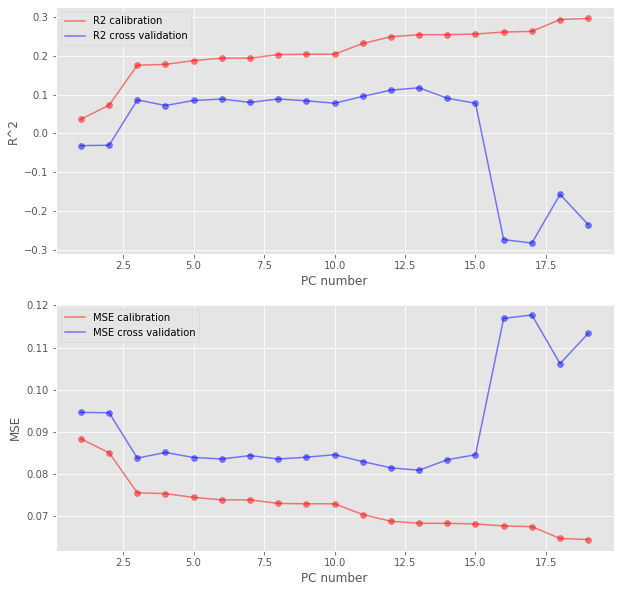

In [114]:
try_different_pc_number(X_uvv_filt_1d)

Still, very bad scores, but 3 components would be the best choice after all.

Let's split the data into the selected number of components

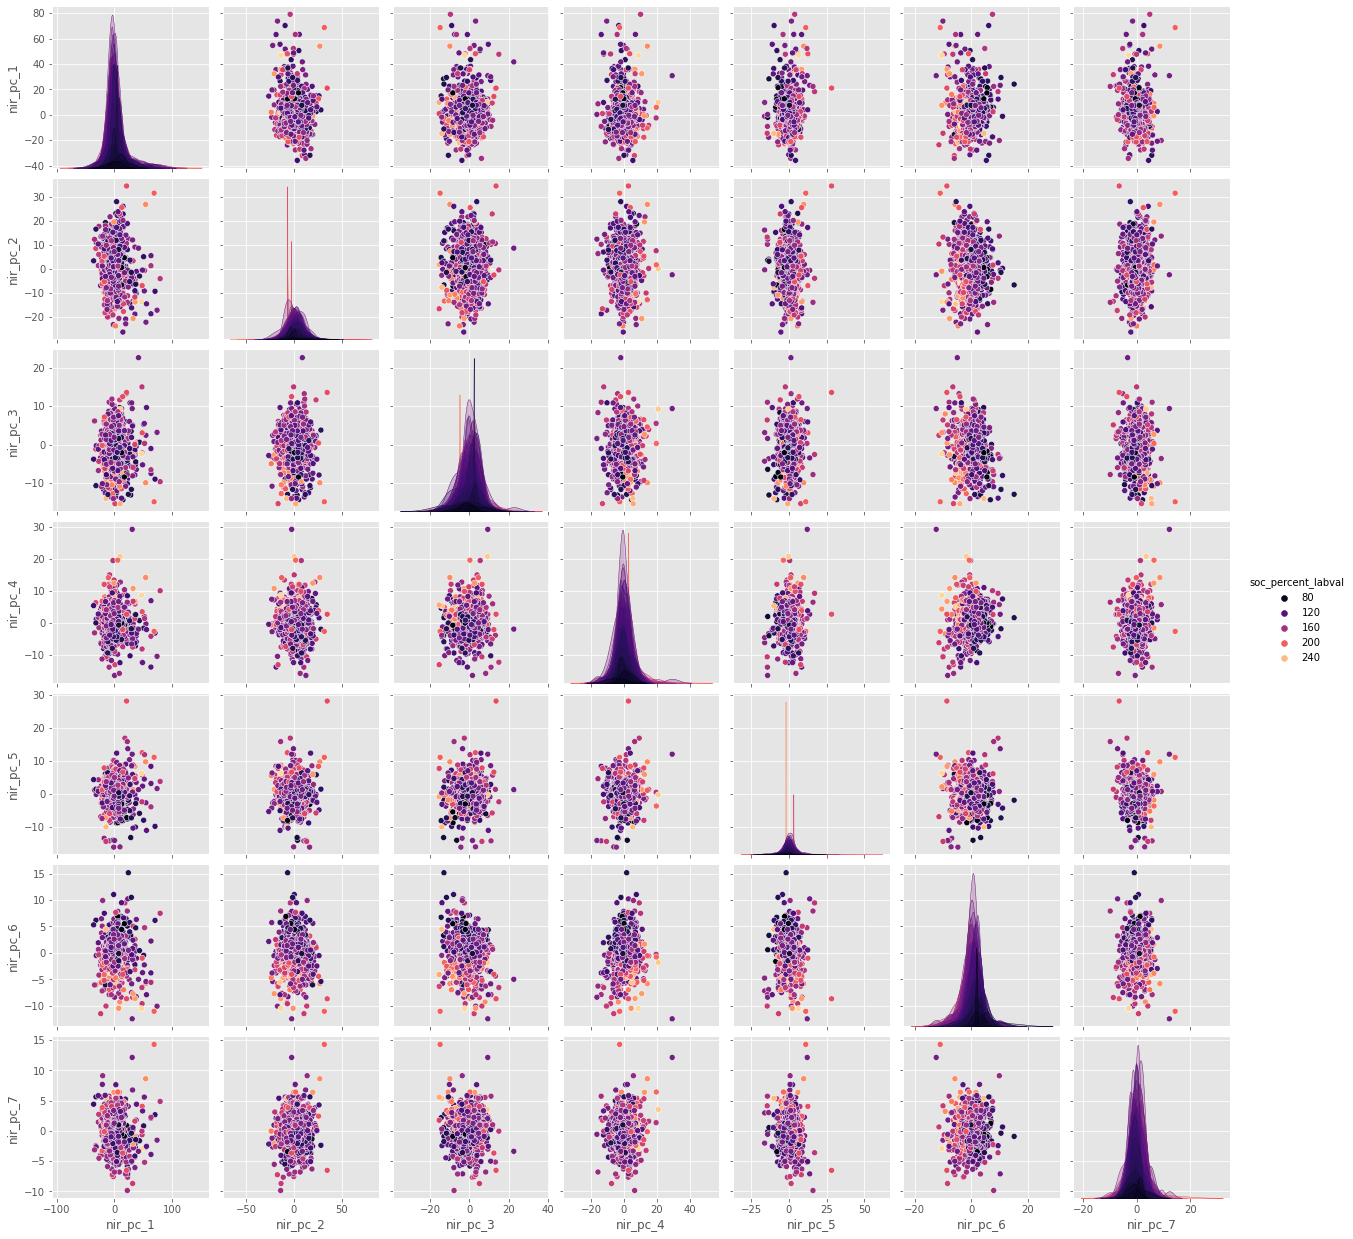

In [115]:
# Split NIR data into 7 PCs
X_nir_1_pca = split_into_pca(7, X_nir_filt_1d, "nir_pc")

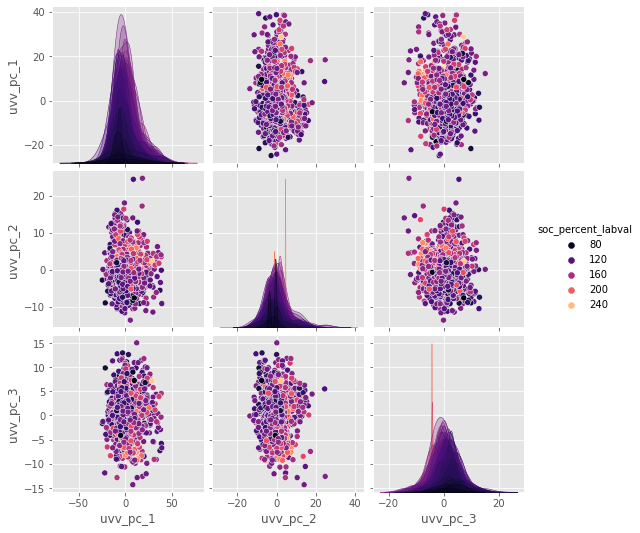

In [116]:
# Split UV/Vi data into 3 components
X_uvv_1_pca = split_into_pca(3, X_uvv_filt_1d, "uvv_pc")

Train a better model that suppose to provide a better performance.

I tried linear regression, XBGBoost regressor with various parameters, and Random Forest Regressor.
However, linear regression performance was the best, so I decided to pick this algorithm again.
(I tried GradBoost/Random Forest on different fields, they also did not outperform linear regression)

MSE: 0.05825462530890809, r2: 0.36511609041648063


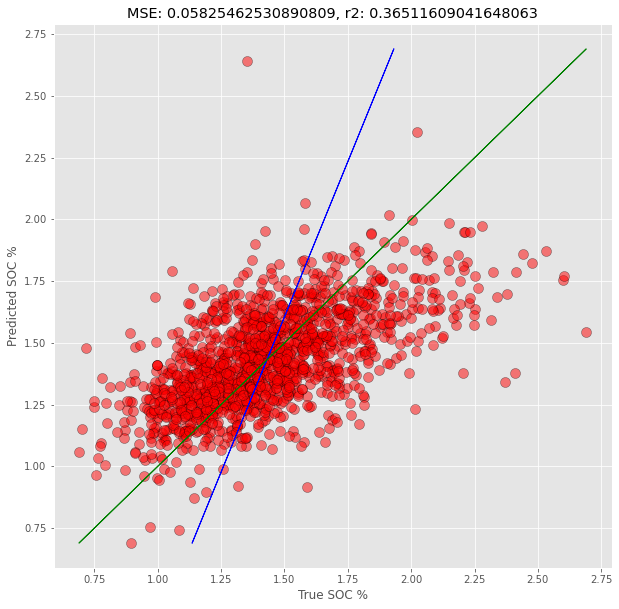

In [117]:
# Let's train a bit better model using the optimised PC numbers
X_better_pca = pd.concat([X_nir_1_pca, X_uvv_1_pca], axis=1)
y_better_pca = df_corrected[SOC_VAL]

better_model = LinearRegression()
# better_model = xgb.XGBRegressor(n_estimators=50, learning_rate=0.15, max_depth=3)
# better_model = RandomForestRegressor(n_estimators=400, max_depth=3)
better_y_cv = cross_val_predict(better_model, X_better_pca, y_better_pca, cv=10)
regression_metrics_and_plot(y_better_pca, better_y_cv)

The result was improved, the cross validation R2 score jumped from almost 0 to 0.36.
Still, not impressive performance, but an improvement.

In [118]:
# I will also check whether the model is efficient when I train and test on different fields.
df_eval_better_model = pd.concat([df_corrected[[SOC_VAL, FIELD_ID]], X_better_pca], axis=1)
eval_on_diff_fields(better_model, df_eval_better_model, X_better_pca.columns)

Train on {'field_B', 'field_C'}, test on field_A:
MSE: 0.0718, R^2: 0.3024
Train on {'field_A', 'field_C'}, test on field_B:
MSE: 0.0409, R^2: 0.3158
Train on {'field_A', 'field_B'}, test on field_C:
MSE: 0.0579, R^2: 0.2117
Train on field_A, test on field_B:
MSE: 0.0490, R^2: 0.1808
Train on field_B, test on field_A:
MSE: 0.0690, R^2: 0.3296
Train on field_A, test on field_C:
MSE: 0.0605, R^2: 0.1772
Train on field_C, test on field_A:
MSE: 0.0765, R^2: 0.2563
Train on field_B, test on field_C:
MSE: 0.0557, R^2: 0.2415
Train on field_C, test on field_B:
MSE: 0.0462, R^2: 0.2274


Solely, training on field A provides the best performance.
Interestingly, that between 2-vs-1 training and testing, the combination of "train on A and B / test on C" shows the worst quality.
I would expect that "train on A and C, test on B" will be the worst one.

In the next model, I will try the second devivative of the NIR spectra.

#### Second NIR devivative

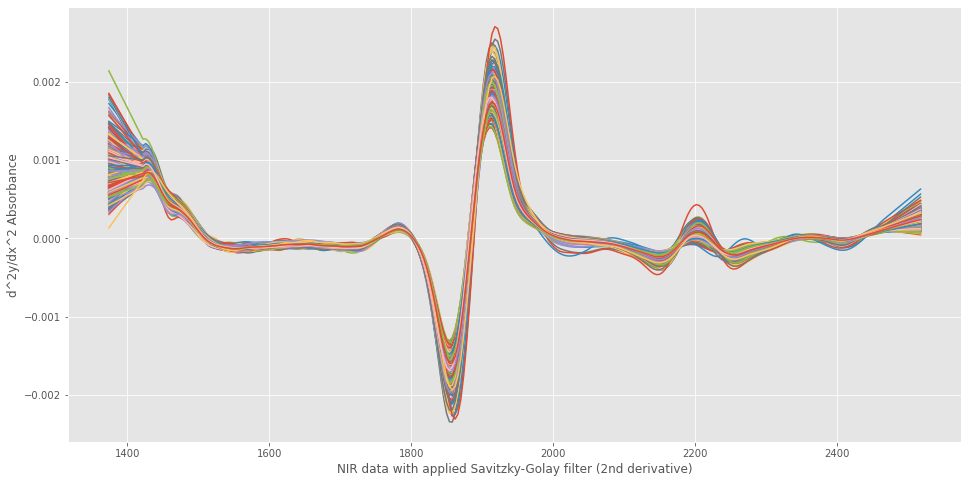

In [119]:
# Let's try second derivative for NIR
# and check whether it provides a better quality
X_nir_filt_2d = savgol_filter(X_nir, 25, polyorder=3, deriv=2)
plt.plot(nir_wavelengths, X_nir_filt_2d.T)
plt.xlabel('Wavelength (nm)')
plt.ylabel('d^2y/dx^2 Absorbance')
plt.xlabel("NIR data with applied Savitzky-Golay filter (2nd derivative)")
plt.show()

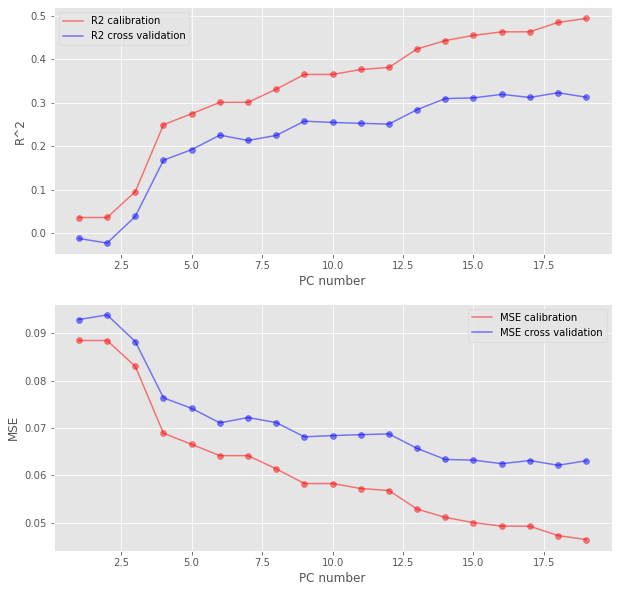

In [120]:
# again, pick the most optimal number of components
try_different_pc_number(X_nir_filt_2d)

In [121]:
# 4 components showed a very bad performance
# What if I select 15?
X_nir_2_pca = split_into_pca(15, X_nir_filt_2d, "nir_pc", no_plot=True)

MSE: 0.05385770446315689, r2: 0.41303562095808255


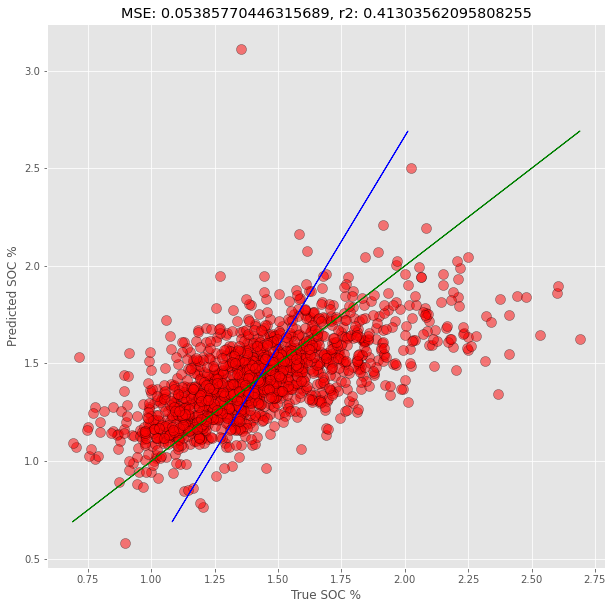

In [122]:
# Let's check a better model where I apply the 2nd NIR derivative
# I will leave UV/Vi spectra PCs as is
X_better_2_pca = pd.concat([X_nir_2_pca, X_uvv_1_pca], axis=1)
better_model_2 = LinearRegression()

# I tried XGBoost and SVM too, but without any significant improved

# better_model_2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.25, max_depth=3)
# better_model_2 = SVR(kernel="rbf", C=0.1, epsilon=0.01)

better_2_y_cv = cross_val_predict(better_model_2, X_better_2_pca, y_better_pca, cv=10)
regression_metrics_and_plot(y_better_pca, better_2_y_cv)

R^2 score improved a bit, let's check whether cross-field results are also better.

The reference from the previous model:
```
Train on {'field_B', 'field_C'}, test on field_A: MSE: 0.07177972868745694, R^2: 0.302393862809606
Train on {'field_C', 'field_A'}, test on field_B: MSE: 0.040903579964733906, R^2: 0.3157795162516709
Train on {'field_B', 'field_A'}, test on field_C: MSE: 0.057920094902120856, R^2: 0.21170623097982655
Train on field_A, test on field_B: MSE: 0.04897334977909562, R^2: 0.1807912875714246
Train on field_B, test on field_A: MSE: 0.06898389168999995, R^2: 0.3295657828443326
Train on field_A, test on field_C: MSE: 0.06045808427327616, R^2: 0.17716413966415967
Train on field_C, test on field_A: MSE: 0.07652543436760983, R^2: 0.25627174075214976
Train on field_B, test on field_C: MSE: 0.05572829698638124, R^2: 0.2415366489521853
Train on field_C, test on field_B: MSE: 0.0461878249827371, R^2: 0.22738655197861413
```

In [123]:
df_eval_better_model = pd.concat([df_corrected[[SOC_VAL, FIELD_ID]], X_better_2_pca], axis=1)
eval_on_diff_fields(better_model, df_eval_better_model, X_better_2_pca.columns)

Train on {'field_B', 'field_C'}, test on field_A:
MSE: 0.0649, R^2: 0.3691
Train on {'field_A', 'field_C'}, test on field_B:
MSE: 0.0350, R^2: 0.4137
Train on {'field_A', 'field_B'}, test on field_C:
MSE: 0.0570, R^2: 0.2242
Train on field_A, test on field_B:
MSE: 0.0804, R^2: -0.3455
Train on field_B, test on field_A:
MSE: 0.0623, R^2: 0.3942
Train on field_A, test on field_C:
MSE: 0.0825, R^2: -0.1222
Train on field_C, test on field_A:
MSE: 0.0721, R^2: 0.2997
Train on field_B, test on field_C:
MSE: 0.0596, R^2: 0.1886
Train on field_C, test on field_B:
MSE: 0.0334, R^2: 0.4411


2-vs-1 scores improved a little.
However, 1-vs-1 scores are worse now, for A-vs-B and A-vs-C they are just terrible.
Yes, 1-vs-1 comparisons do not provide a plenty of training data.
Also, I got a feeling that field A data was not properly filtered -> again, models trained solely on field A provide the worst performance.


### PLS regression

For now I will check whether PLS regression provides a better performance.
First, I will start with a simple function that tries different number of components and computes MSE + R2 scores for each.
Then it will suggest a number of components + build regression plot.

Optimal number of components: 49


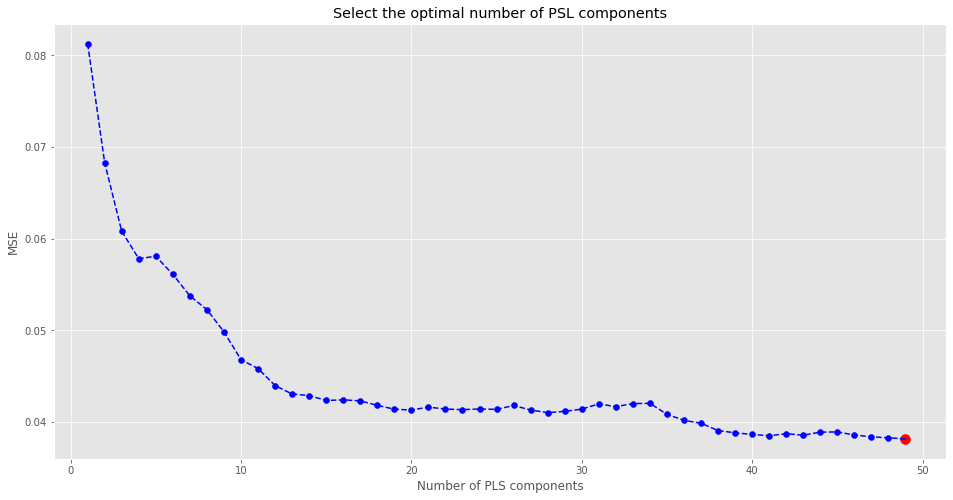

MSE: 0.038143091877654176, r2: 0.5843002136486941


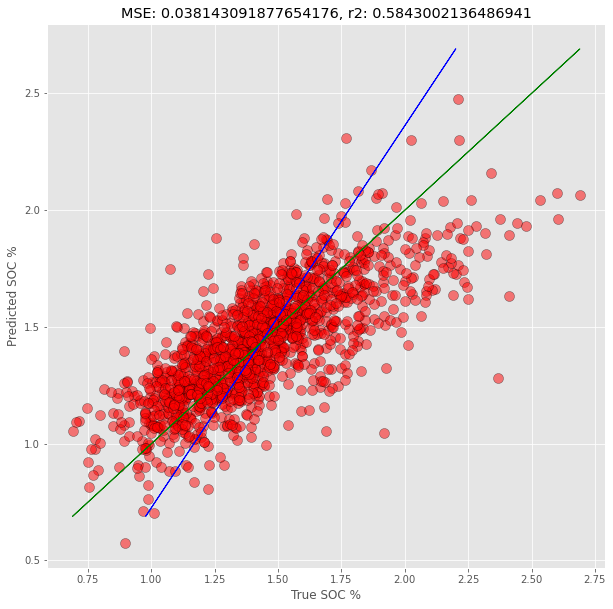

In [124]:
def select_opt_pls_num(X, y, n_comp, plot_components=True):
    """"""
    mses = []
    component = np.arange(1, n_comp)

    # Collect MSE for each number of components
    for i in component:
        pls = PLSRegression(n_components=i)
        y_cv = cross_val_predict(pls, X, y, cv=10)
        mses.append(mean_squared_error(y, y_cv))
 
    # Select the optimal number of components
    mse_min = np.argmin(mses)
    best_num_of_pc = mse_min + 1
    print(f"Optimal number of components: {best_num_of_pc}")

    # Build the MSE vs number of components plot
    plt.plot(component, np.array(mses), '--', color='blue')
    plt.scatter(component, np.array(mses), color='blue')
    plt.scatter(component[mse_min], np.array(mses)[mse_min], s=100, color='red')
    plt.title('Select the optimal number of PSL components')
    plt.xlabel('Number of PLS components')
    plt.ylabel('MSE')
    plt.xlim(left=-1)
    plt.show()
 
    # Evaluate PLS model on the whole test set with the selected number of components
    pls_opt = PLSRegression(n_components=best_num_of_pc)
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    regression_metrics_and_plot(y, y_cv)
    return best_num_of_pc, pls_opt

X_nir_opt_num_of_pc, nir_pls_model = select_opt_pls_num(X_nir_filt_2d, df_corrected[SOC_VAL], 50, plot_components=True)

Partial least squares regression proposed 49 components.
The cross-validation result on NIR data is much better than the previous model.
But I am afraid of overfitting for such a number of components.
-> I will surely check the model on different fields

Optimal number of components: 34


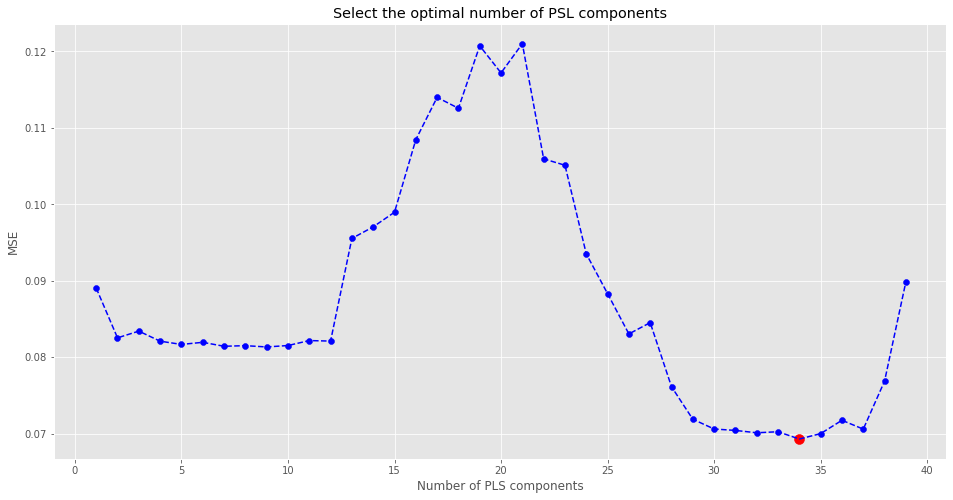

MSE: 0.06929706257679713, r2: 0.24477086964143424


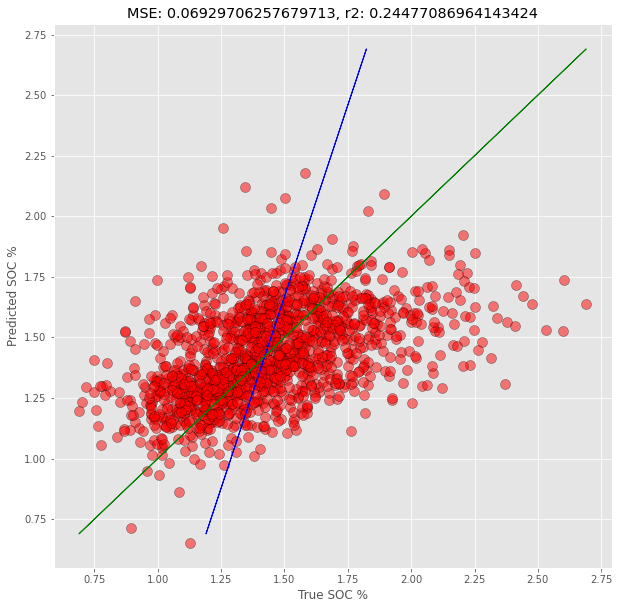

In [125]:
# let's repeat the save for UV/Vi
X_uvv_opt_num_of_pc, uvv_pls_model = select_opt_pls_num(X_uvv_filt_1d, df_corrected[SOC_VAL], 40, plot_components=True)

I don't fully understand where those warnings come from...

MSE: 0.03653717159275264, r2: 0.601802222176794


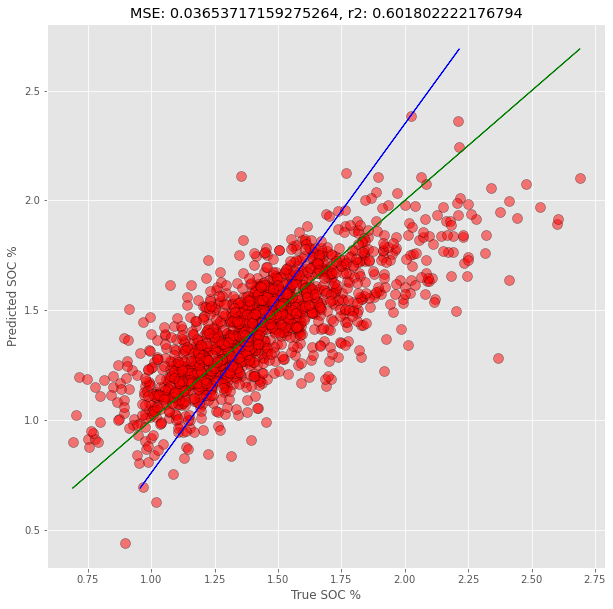

In [126]:
# PLS suggested to use a greater number of components
# Let's repeat the previous procedure with PC split and check whether these #PC will improve the model
X_nri_d2_best_pca = split_into_pca(X_nir_opt_num_of_pc, X_nir_filt_2d, "nir_pc", no_plot=True)
X_uvv_d1_best_pca = split_into_pca(X_uvv_opt_num_of_pc, X_uvv_filt_1d, "uvv_pc", no_plot=True)
X_psl_optimised= pd.concat([X_nri_d2_best_pca, X_uvv_d1_best_pca], axis=1)

psl_opt_model = LinearRegression()
# I tried other classifiers again but still, LinearRegression performs better
# psl_opt_model = xgb.XGBRegressor(n_estimators=100, eta=0.15, max_depth=7)
# psl_opt_model = SVR(kernel="rbf", C=0.1, epsilon=0.01)

# cross val predict -> retuns an array of exactly the same shape as y, but produced vla cross validated predictionsy
y_psl_optimised_cv = cross_val_predict(psl_opt_model, X_psl_optimised, y_better_pca, cv=10)
# evaluate the baseline model
regression_metrics_and_plot(y_better_pca, y_psl_optimised_cv)

Well, cross-validation score is better now.
But what will happen if I train and test this model on different fields?

In [127]:
df_psl_opt_model = pd.concat([df_corrected[[SOC_VAL, FIELD_ID]], X_psl_optimised], axis=1)
eval_on_diff_fields(psl_opt_model, df_psl_opt_model, X_psl_optimised.columns)

Train on {'field_B', 'field_C'}, test on field_A:
MSE: 0.0491, R^2: 0.5223
Train on {'field_A', 'field_C'}, test on field_B:
MSE: 0.0385, R^2: 0.3568
Train on {'field_A', 'field_B'}, test on field_C:
MSE: 0.0363, R^2: 0.5061
Train on field_A, test on field_B:
MSE: 3.3268, R^2: -54.6494
Train on field_B, test on field_A:
MSE: 51.8425, R^2: -502.8420
Train on field_A, test on field_C:
MSE: 0.1918, R^2: -1.6104
Train on field_C, test on field_A:
MSE: 0.0673, R^2: 0.3461
Train on field_B, test on field_C:
MSE: 32.5710, R^2: -442.2919
Train on field_C, test on field_B:
MSE: 0.0484, R^2: 0.1908


I got a significant improvement in 2-vs-1 validations.
But 1-vs-1 validation is even worse than in the previous model.

#### Leave-one-out feature selection

I decided to try the following:
- Split the spectra into bands.
- Exclude bands that are deleterious to the model performance.

I will exclude bands one-by-one and evaluate how does it affect the metrics.

In [128]:
X_nir_filt_0d = savgol_filter(X_nir, window_length=25, polyorder=3,  deriv=1)
X_uvv_filt_0d = savgol_filter(X_uvv, window_length=25, polyorder=3, deriv=1)
print(X_nir_filt_0d.shape)
print(len(X_nir_filt_0d[0]) * 4)
# can split 287 wavelengths into 41 bands with 7 measurements in each -> 7 * 4 = 28nm per band
print(X_uvv_filt_0d.shape)  # with 2 nm step
print(len(X_uvv_filt_0d[0]) * 2)
# from UV/Vi, I remote first 2 wavelengths to get 184, which is divisible by 23
# It will be 23 * 2 = 46nm per band, 8 bands in total
# feels like this is an auxiliary spectra, so I will be fine with that
X_uvv_filt_02_drop_2 = X_uvv_filt_0d[: , 2:]
uvv_columns_drop_2 = uvv_columns[2:]
uvv_wavelengths_drop_2 = uvv_wavelengths[2:]

(1471, 287)
1148
(1471, 186)
372


In [129]:
X_nir_r = X_nir_filt_0d.reshape(X_nir_filt_0d.shape[0], 41, 7).sum(axis=2)
print(f"X NIR shrinked shape: {X_nir_r.shape}")
X_uvv_r = X_uvv_filt_02_drop_2.reshape(X_uvv_filt_0d.shape[0], 8, 23).sum(axis=2)
print(f"X UVV shrunk shape: {X_uvv_r.shape}")

X_bands = np.concatenate((X_nir_r, X_uvv_r), axis=1)
print(X_bands.shape)

X NIR shrinked shape: (1471, 41)
X UVV shrunk shape: (1471, 8)
(1471, 49)


In [130]:
def pls_optimise_components(X, y, n_max):
    """Find optimal number of components for a given X&y."""
    mse_scores = []
    for i in range(1, n_max + 1, 1):
        # Collect MSE for each component #
        pls_simple = PLSRegression(n_components=i)
        pls_simple.fit(X, y)
        y_cv = cross_val_predict(pls_simple, X, y, cv=10)
        score = r2_score(y, y_cv)
        mse_scores.append(mean_squared_error(y, y_cv))
    opt_comp_num = np.argmin(mse_scores) + 1
    mse_min = np.argmin(mse_scores)
    return opt_comp_num, mse_min


def pls_train_val(X, y, n):
    """Just train and cross validate RLS model with n commponents."""
    pls_simple = PLSRegression(n_components=n)
    pls_simple.fit(X, y)
    y_cv = cross_val_predict(pls_simple, X, y, cv=10)
    r2_ = r2_score(y, y_cv)
    mse_ = mean_squared_error(y, y_cv)
    return(y_cv, mse_, r2_)


r2_mse_cv = []
loo = LeaveOneOut()
band_numbers_np = np.linspace(1, X_bands.shape[1], X_bands.shape[1])

# Loop over the bands leaving one out
for kept_band_numbers, _ in loo.split(band_numbers_np):
    # Optimise and fit a RLS regression model
    opt_comp_num, _ = pls_optimise_components(X_bands[:, kept_band_numbers], y_better_pca, 10)
    _, _, mse_ = pls_train_val(X_bands[:, kept_band_numbers], y_better_pca, opt_comp_num)
    r2_mse_cv.append(mse_)

r2_mse_cv = np.array(r2_mse_cv)

[]

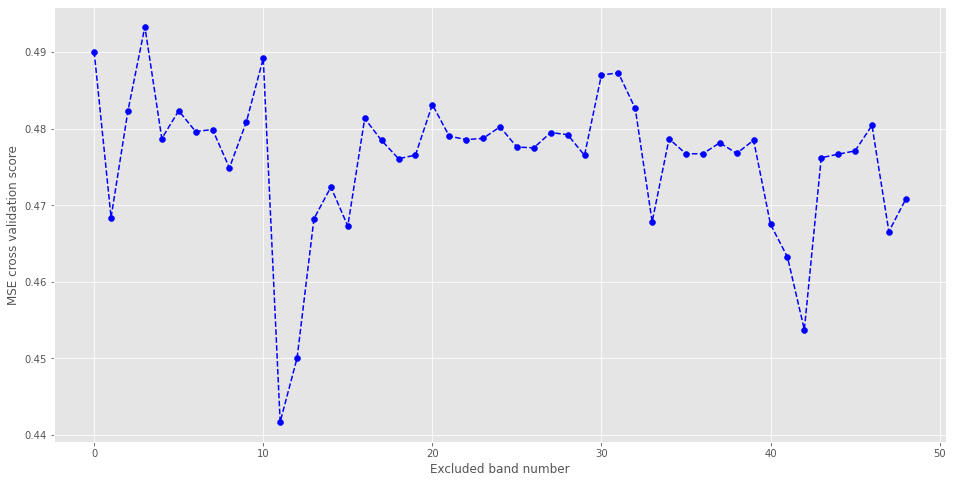

In [131]:
# Plot MSEs for each band being removed
plt.plot(list(range(49)), r2_mse_cv, '--', color="blue")
plt.scatter(list(range(49)), r2_mse_cv, color="blue")
plt.xlabel('Excluded band number')
plt.ylabel('MSE cross validation score')
plt.plot()

The ideal solution would be:

- While iter_num < 40:
-     mse_list = []
-     for band_number:
-         evaluate_mse when this band is excluded
-         add value to mse_list
-    identify band corresponding to the smallest mse
-    if the smallest_mse is not smaller than previous:
-        break
-     # removing this band resulted in the best result
-     exlude from the dataset, repeat

as the result, I should get a better collection of features for training

Because of the time pressure, I selected features to be removed manually.
But this is not the best solution.

In [132]:
X_bands_opt = X_bands.copy()
band_numbers_opt = band_numbers_np.copy()
print(X_bands_opt.shape)

X_bands_opt = np.delete(X_bands_opt, [1, 8, 11, 12, 13, 14, 15, 33, 40, 41, 42, 47], 1)

(1471, 49)


MSE: 0.06560425913440258, r2: 0.28501662651307635


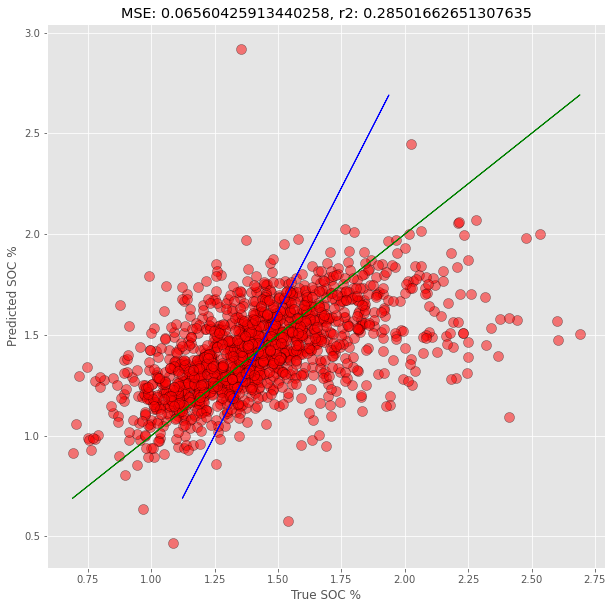

In [133]:
feat_opt_model = LinearRegression()
# feat_opt_model = xgb.XGBRegressor(n_estimators=50, eta=0.1, max_depth=4)
# feat_opt_model = SVR(kernel="rbf", C=200, epsilon=0.01)
feat_opt_y = cross_val_predict(feat_opt_model, X_bands_opt, y_better_pca, cv=10)
regression_metrics_and_plot(y_better_pca, feat_opt_y)

I guess automated solution as stated above would increase the score. However, this is still an improvement over the baseline model. I believe, that proper feature selection would increase the score even more. Maybe, it could even outperform the previous model.

In [134]:
Xr_optim_df = pd.DataFrame(X_bands_opt)
df_feat_opt_model = pd.concat([df_corrected[[SOC_VAL, FIELD_ID]], Xr_optim_df], axis=1)
eval_on_diff_fields(feat_opt_model, df_feat_opt_model, Xr_optim_df.columns)

Train on {'field_B', 'field_C'}, test on field_A:
MSE: 0.0898, R^2: 0.1274
Train on {'field_A', 'field_C'}, test on field_B:
MSE: 0.0501, R^2: 0.1624
Train on {'field_A', 'field_B'}, test on field_C:
MSE: 0.0676, R^2: 0.0797
Train on field_A, test on field_B:
MSE: 0.0667, R^2: -0.1160
Train on field_B, test on field_A:
MSE: 0.0978, R^2: 0.0498
Train on field_A, test on field_C:
MSE: 0.0749, R^2: -0.0197
Train on field_C, test on field_A:
MSE: 0.0926, R^2: 0.1004
Train on field_B, test on field_C:
MSE: 0.0584, R^2: 0.2058
Train on field_C, test on field_B:
MSE: 0.0427, R^2: 0.2854


### Conclusion

I could create models with MSE and R2 scores higher than a baseline. However, the regression quality is far from perfect and, of course, could be improved.

Some directions for further model improvement could be:

- Analyze field A thoroughly. Models trained solely on field A show the worst performance; its southern part also stands out (mean SOC value, many UV/Vi spectra have an unusual shape, etc.) I believe that model can be improved if I could filter data coming from field A more carefully. Maybe even excluding the clusters located around the pond -> they are probably responsible for anomalies. Initially, I thought that field B would bring anomalies.
- More careful features engineering. One idea would be to combine principal components with selected bands. Also, some of the spectra bands are associated with particular chemical bounds; and this information can be used (or is it, in contrast, deleterious)?
- About features again: implement automatic solution for deleting bands one-by-one until deleting bands does not improve classification score. For time reasons, I did not implement this and tried manual features picking. Of course, this is not the best approach.
- Try more different regressors, kernels, and parameters. For example, I could invest more time in parameter tuning for SVM or gradient boosting and would not be surprised if I get higher quality than a basic linear regression. Also, I could use PLS and PCR regression for classification, not only for the feature selection.
- There is a chance that I could extract more data from visible light that may be helpful. I concentrated a lot on NIR spectra and used VI as auxiliary data. Some chemical compounds also absorb and emit visible light.
